In [1]:
import quantum_kan 
import symengine as se
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import mean_squared_error, r2_score
from pyqubo import Binary, Array
import os
from dwave.embedding.chain_breaks import majority_vote
from dimod import BinaryQuadraticModel
import dwave.inspector
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, FixedEmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn
import minorminer
import networkx as nx

# Set your D-Wave API token
import os
# env_vars = !cat dwave.env
# for var in env_vars:
#     key, value = var.split('=')
#     os.environ[str(key)] = str(value)
# #Advantage_system6.4 or Advantage2_prototype2.3
# sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
# hybrid_sampler = LeapHybridSampler(solver="hybrid_binary_quadratic_model_version2")

simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")


Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' in part) or ('AUX' in part):
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)
    
def separate_vars(solution):
    """
    Separate coefficients and auxiliary variables from the solution dictionary.

    :param solution: The solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {k: v for k, v in solution.items() if k.startswith('aux')}
    coeff_vars = {k: v for k, v in solution.items() if k.startswith('coeff')}
    
    return aux_vars, coeff_vars

def create_reverse_lookup_dict(original_dict):
    """
    Create a reverse lookup dictionary from the given dictionary.

    :param original_dict: The original dictionary to reverse.
    :return: A new dictionary where keys are the original values and values are the original keys.
    """
    reverse_dict = {v: k for k, v in original_dict.items()}
    return reverse_dict

def map_solution_variables(solution, reverse_dict):
    """
    Map solution variables from PyQUBO to SymPy using the reverse dictionary.

    :param solution: The solution dictionary with PyQUBO variables.
    :param reverse_dict: The reverse lookup dictionary to map PyQUBO variables to SymPy variables.
    :return: A new dictionary with SymPy variables as keys and solution values.
    """
    mapped_solution = {}
    for pyqubo_var, value in solution.items():
        sympy_var = reverse_dict.get(Binary(pyqubo_var))
        if sympy_var is not None:
            mapped_solution[sympy_var] = value
        else:
            print(f"Warning: PyQUBO variable {pyqubo_var} not found in reverse mapping.")
    return mapped_solution

def separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary=False):
    """
    Separate coefficients and auxiliary variables from the mapped solution dictionary.

    :param mapped_solution: The mapped solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if str(k).replace('"','').replace("'","").startswith('AUX')}
    if include_aux_in_binary == True:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if  str(k).replace('"','').replace("'","")}
    else:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if not str(k).replace('"','').replace("'","").startswith('AUX')}
    
    return aux_vars, binary_vars

def check_aux_variables(binary_vars, aux_vars, aux_dict_all):
    """
    Check if auxiliary variables correctly represent the product of their respective binary variables.

    :param binary_vars: Dictionary of binary variable values (e.g., {'x1': 0, 'x2': 1, ...})
    :param aux_vars: Dictionary of auxiliary variable values (e.g., {'z1': 1, 'z2': 0, ...})
    :param aux_dict_all: Dictionary mapping auxiliary variables to their respective binary variable products
                         (e.g., {'z1': x1*x2, 'z2': x2*x3, ...})
    :return: Dictionary indicating whether each auxiliary variable is correct (e.g., {'z1': True, 'z2': False, ...})
    """
    results = {}

    for aux_var, aux_expr in aux_dict_all.items():
        # Extract the binary variables involved in the product
        vars_in_expr = aux_expr.split('*')
        product_value = 1
        aux_var = str(aux_var)

        # Calculate the expected value by multiplying the values of the binary variables
        for var in vars_in_expr:
            var = str(var)
            if var in binary_vars:
                product_value *= binary_vars[var]
            else:
                raise ValueError(f"Variable {var} not found in binary_vars dictionary")

        # Check if the auxiliary variable's value matches the expected product value
        if aux_var in aux_vars:
            results[aux_var] = (aux_vars[aux_var] == product_value)
        else:
            raise ValueError(f"Auxiliary variable {aux_var} not found in aux_vars dictionary")

    return results
    
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [0,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = (train_label - mean_label) / std_label
        test_label = (test_label - mean_label) / std_label

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

def split_dataset(dataset, splits):
    """
    Split dataset into multiple smaller datasets.
    
    Args:
    -----
        dataset : dict
            The dataset containing 'train_input' and 'train_label'.
        splits : list
            List of integers specifying the size of each split.
            
    Returns:
    --------
        split_datasets : list
            List of datasets, each containing 'train_input' and 'train_label'.
    """
    total_size = sum(splits)
    assert total_size == len(dataset['train_input']), "Sum of splits must equal the total dataset size."
    
    # Create a list of indices and shuffle them
    indices = torch.randperm(total_size)
    
    split_datasets = []
    start_idx = 0
    
    for split_size in splits:
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        
        split_input = dataset['train_input'][split_indices]
        split_label = dataset['train_label'][split_indices]
        
        split_dataset = {
            'train_input': split_input,
            'train_label': split_label,
            'test_input': torch.empty(0, split_input.shape[1]),  # Empty tensor with the same number of columns as train_input
            'test_label': torch.empty(0, split_label.shape[1])   # Empty tensor with the same number of columns as train_label
        }
        
        split_datasets.append(split_dataset)
        start_idx = end_idx
        
    return split_datasets



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, T, U, Z_ideal, Z_ideal_flat):
    best_lr = None
    best_mse = 100000
    grid_points = np.c_[T.ravel(), U.ravel()]
    grid_points_tensor = torch.from_numpy(grid_points).float()

    for lr in learning_rates:
        model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr)
        end = time.perf_counter()
        training_time = end - start
        print(f"Training time in seconds of lr={lr}: {training_time}")  # will print the elapsed time in seconds

        # Compute the model predictions
        with torch.no_grad():
            Z_model = model(grid_points_tensor).numpy().reshape(T.shape)
            
        # Flatten the arrays for comparison
        Z_model_flat = Z_model.ravel()

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(Z_ideal_flat, Z_model_flat)
        r2 = r2_score(Z_ideal_flat, Z_model_flat)
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
        print(f"Learning Rate: {lr}, Train MSE: {mse}, Train r2: {r2}")

    print(f"Best Learning Rate: {best_lr} with Train MSE: {best_mse}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()


    start = time.perf_counter()

    results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=best_lr)
    end = time.perf_counter()
    time_best_lr = end - start

    print(f"Training time in seconds: {time_best_lr}")  # will print the elapsed time in seconds

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Compute the model predictions
    with torch.no_grad():
        Z_model = model(grid_points_tensor).numpy().reshape(T.shape)

    # Plot the ideal function
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {time_best_lr}, mse: {mse}, r2: {r2}")

    return time_best_lr, mse, r2

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=1000, annealing_time=20):
    #Check if quantum annealer, hybrid quantum annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on quantum annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds
    print(f"optimized_coefficients_1: {optimized_coefficients_1}")
    print(f"optimized_coefficients_2: {optimized_coefficients_2}")
    print(f"optimized_coefficients_3: {optimized_coefficients_3}")

    # Separate coefficients and auxiliary variables
    aux_vars, coeff_vars = separate_vars(solution)
    # Create reverse lookup dictionary
    reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
    # Map solution variables from PyQUBO to SymPy
    mapped_solution = map_solution_variables(solution, reverse_dict)
    include_aux_in_binary = True
    aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
    # Check the auxiliary variable values
    results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

    # Print the results
    for aux_var, is_correct in results_aux_check.items():
        print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    # Plotting the 3D surface plots side by side
    fig = plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Quantum Annealing Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {total_time_optimization}, MSE: {mse:.4f}, r2: {r2:.4f}")
    print(f"time_part1: {time_part1}, time_part2: {time_part2}, time_part3: {time_part3}")
    return time_part2, time_part3, total_time_optimization, mse, r2

In [5]:
# Define the spherical harmonic function for m=0 and n=1
def spherical_harmonic_m0_n1(x):
    theta = x[:, 0] * np.pi  # Scale to range [0, pi]
    phi = x[:, 1] * 2 * np.pi  # Scale to range [0, 2*pi]
    y = (np.sqrt(3 / (4 * np.pi)) * np.cos(theta) + 0.5)
    return torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [6]:
# Defining variables for the networks
degree1 = 1
degree2 = 1
degree3 = 1
degrees=[degree1,degree3]
m1 = 1
m2 = 2
m3 = 3
function_multiplier = 1
penalty_multiplier = 25
bias_coefficient = 0.0
is_fractional=True

num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1
num_basis_funcs_3 = degree3 + 1

save_file1 = "sph_harm_hybrid_retraining_mse_save1.json"
save_file2 = "sph_harm_hybrid_retraining_mse_save2.json"
save_file3 = "sph_harm_hybrid_retraining_mse_save3.json"
save_file4 = "sph_harm_hybrid_retraining_mse_save4.json"

# Define variables to keep track of time
total_time_quantum = []
total_time_hybrid = []
total_time_simulated = []
total_time_adam = []
total_time_sgd = []
total_time_adagrad = []

In [7]:
dataset_size = 1400000
# Create dataset with normalized inputs between 0 and 1
dataset = create_dataset(spherical_harmonic_m0_n1, n_var=2, train_num=dataset_size, test_num=0, ranges=[0, 1])

# Define the sizes of the splits
splits = [1000000, 100000, 100000, 100000, 100000]

# Split the dataset
split_datasets = split_dataset(dataset, splits)

# Example usage
for i, split_dataset in enumerate(split_datasets):
    print(f"Dataset {i+1}:")
    print(f"  Input shape: {split_dataset['train_input'].shape}")
    print(f"  Label shape: {split_dataset['train_label'].shape}")
    if i == 0:
        dataset = split_dataset
    elif i == 1:
        dataset_split1 = split_dataset
    elif i == 2:
        dataset_split2 = split_dataset
    elif i == 3:
        dataset_split3 = split_dataset
    elif i == 4:
        dataset_split4 = split_dataset
    
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

# Make z_ideal
# Define the spherical harmonic function for m=0 and n=1
def spherical_harmonic_m0_n1_scaled(t, u, multiplier):
    theta = t * np.pi  # Scale t to range [0, pi]
    phi = u * 2 * np.pi  # Scale u to range [0, 2*pi]
    return (np.sqrt(3 / (4 * np.pi)) * np.cos(theta) + 0.5) * multiplier

# Generate a grid of t and u values for the 3D plot
t_values = np.linspace(0, 1, 30)
u_values = np.linspace(0, 1, 30)
T, U = np.meshgrid(t_values, u_values)

# Compute the ideal function values
Z_ideal = np.array([[spherical_harmonic_m0_n1_scaled(t, u, function_multiplier) for t, u in zip(t_row, u_row)] for t_row, u_row in zip(T, U)])
Z_ideal_flat = Z_ideal.ravel()

Dataset 1:
  Input shape: torch.Size([1000000, 2])
  Label shape: torch.Size([1000000, 1])
Dataset 2:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 3:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 4:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 5:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])


/tmp/ipykernel_43306/1510031437.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


# Run Quantum Annealing

In [13]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    print(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

print(coefficients_aux_np)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()
    

AUX0
AUX39
AUX28
AUX38
AUX12
AUX8
AUX37
AUX11
AUX26
AUX25
AUX17
AUX6
AUX14
AUX22
AUX15
AUX19
AUX10
AUX21
AUX16
AUX33
AUX20
AUX18
AUX42
AUX24
AUX2
AUX27
AUX36
AUX1
AUX7
AUX40
AUX3
AUX29
AUX41
AUX30
AUX34
AUX23
AUX4
AUX31
AUX32
AUX35
AUX13
[Binary('aux[0]') Binary('aux[1]') Binary('aux[2]') Binary('aux[3]')
 Binary('aux[4]') Binary('aux[5]') Binary('aux[6]') Binary('aux[7]')
 Binary('aux[8]') Binary('aux[9]') Binary('aux[10]') Binary('aux[11]')
 Binary('aux[12]') Binary('aux[13]') Binary('aux[14]') Binary('aux[15]')
 Binary('aux[16]') Binary('aux[17]') Binary('aux[18]') Binary('aux[19]')
 Binary('aux[20]') Binary('aux[21]') Binary('aux[22]') Binary('aux[23]')
 Binary('aux[24]') Binary('aux[25]') Binary('aux[26]') Binary('aux[27]')
 Binary('aux[28]') Binary('aux[29]') Binary('aux[30]') Binary('aux[31]')
 Binary('aux[32]') Binary('aux[33]') Binary('aux[34]') Binary('aux[35]')
 Binary('aux[36]') Binary('aux[37]') Binary('aux[38]') Binary('aux[39]')
 Binary('aux[40]')]
Time taken for elapsed

Invalid coefficient: AUX3


In [14]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 1.9731097840012808


quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=3000, annealing_time=20)

hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.218371007002133
Time spent on part 3: 0.001389144999848213
Time spent on optimization: 11.47015196400389
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.0]
optimized_coefficients_3: [1.75, 0.0]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 11.47015196400389, MSE: 0.1044, r2: 0.1532
time_part1: 2.250391812001908, time_part2: 9.218371007002133, time_part3: 0.001389144999

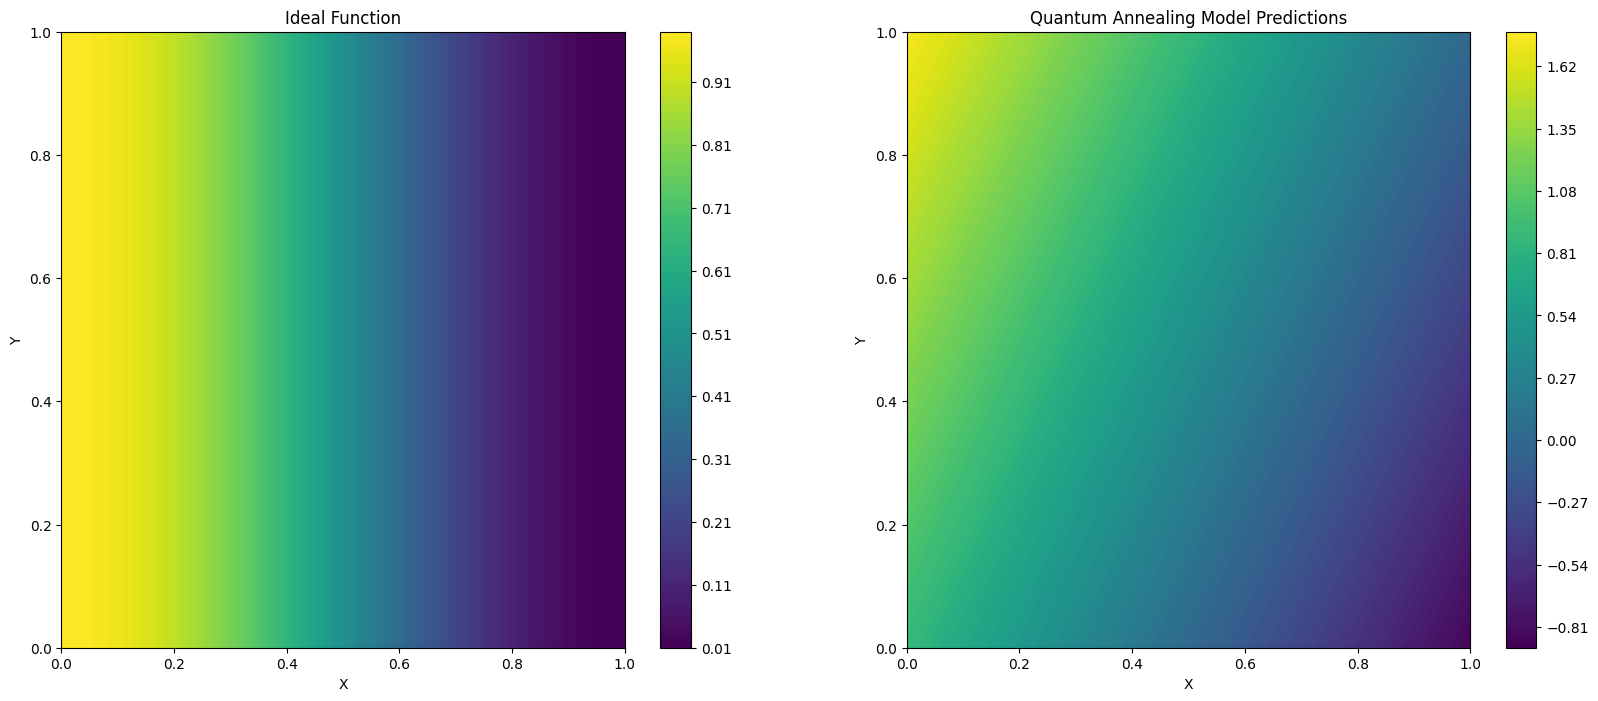

In [10]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.69e-01 | test loss: nan | reg: 3.43e+00 : 100%|███████| 50/50 [00:26<00:00,  1.88it/s]


Training time in seconds of lr=0.001: 26.63076817000001
Learning Rate: 0.001, Train MSE: 0.31335322247726444, Train r2: -1.54045982377616


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.80e-01 | test loss: nan | reg: 3.37e+00 : 100%|███████| 50/50 [00:25<00:00,  1.98it/s]


Training time in seconds of lr=0.01: 25.269768699999986
Learning Rate: 0.01, Train MSE: 0.054232685791209226, Train r2: 0.5603174006035962


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.54e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:23<00:00,  2.11it/s]


Training time in seconds of lr=0.05: 23.667246408999745
Learning Rate: 0.05, Train MSE: 0.002144837631850327, Train r2: 0.9826110809100286


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.56e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:23<00:00,  2.11it/s]


Training time in seconds of lr=0.1: 23.719015099999524
Learning Rate: 0.1, Train MSE: 0.0024534791344550527, Train r2: 0.9801088205818327


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.27e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:23<00:00,  2.10it/s]


Training time in seconds of lr=0.2: 23.80070951899961
Learning Rate: 0.2, Train MSE: 0.0025990716897902537, Train r2: 0.9789284528340689


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.51e-02 | test loss: nan | reg: 2.62e+00 : 100%|███████| 50/50 [00:24<00:00,  2.07it/s]


Training time in seconds of lr=0.5: 24.111766107999756
Learning Rate: 0.5, Train MSE: 0.0024774620528202995, Train r2: 0.9799143830072574
Best Learning Rate: 0.05 with Train MSE: 0.002144837631850327


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:23<00:00,  2.11it/s]


Training time in seconds: 23.74489277399971
Layer 0 Bezier coefficients:
[[-0.9522669   0.56216097]
 [ 0.09456824  0.09599318]]
Layer 1 Bezier coefficients:
[[ 0.37777206 -0.1589323 ]]


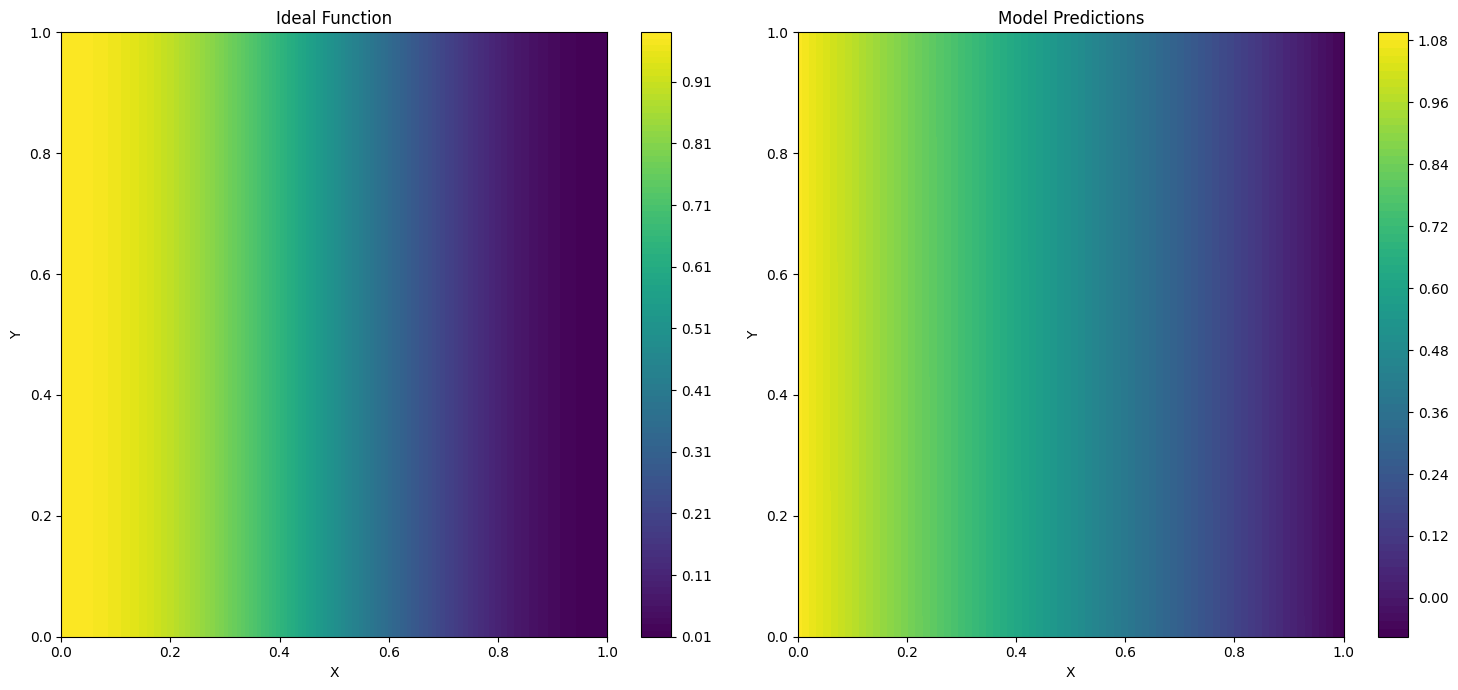

Training time: 23.74489277399971, mse: 0.002144769302412746, r2: 0.9826116348797296


In [14]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
adam_steps = 50
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(dataset, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.76e-01 | test loss: nan | reg: 2.76e+00 : 100%|███████| 50/50 [00:23<00:00,  2.11it/s]


Training time in seconds of lr=0.001: 23.663655512999867
Learning Rate: 0.001, Train MSE: 0.3284165227915644, Train r2: -1.6625830588889903


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.97e-01 | test loss: nan | reg: 6.96e+00 : 100%|███████| 50/50 [00:23<00:00,  2.11it/s]


Training time in seconds of lr=0.01: 23.652051852000113
Learning Rate: 0.01, Train MSE: 0.14301517727667132, Train r2: -0.15947207815285802


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.29e+00 : 100%|███████| 50/50 [00:23<00:00,  2.13it/s]


Training time in seconds of lr=0.05: 23.474025815999994
Learning Rate: 0.05, Train MSE: 0.08154724604555547, Train r2: 0.3388690862007836


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.00e-01 | test loss: nan | reg: 1.28e+00 : 100%|███████| 50/50 [00:23<00:00,  2.15it/s]


Training time in seconds of lr=0.1: 23.213909756999783
Learning Rate: 0.1, Train MSE: 0.014447360274832139, Train r2: 0.8828703976692189


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:24<00:00,  2.00it/s]


Training time in seconds of lr=0.2: 24.948675260000527
Learning Rate: 0.2, Train MSE: 0.0020868937588015596, Train r2: 0.9830808513510365


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 2.31e+00 : 100%|███████| 50/50 [00:24<00:00,  2.05it/s]


Training time in seconds of lr=0.5: 24.383159805000105
Learning Rate: 0.5, Train MSE: 0.005601354167209992, Train r2: 0.954587940382293
Best Learning Rate: 0.2 with Train MSE: 0.0020868937588015596


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:24<00:00,  2.06it/s]


Training time in seconds: 24.25105934200019
Layer 0 Bezier coefficients:
[[-0.42536858  0.5403133 ]
 [ 0.05548474  0.05470474]]
Layer 1 Bezier coefficients:
[[ 0.5407675  -0.33794746]]


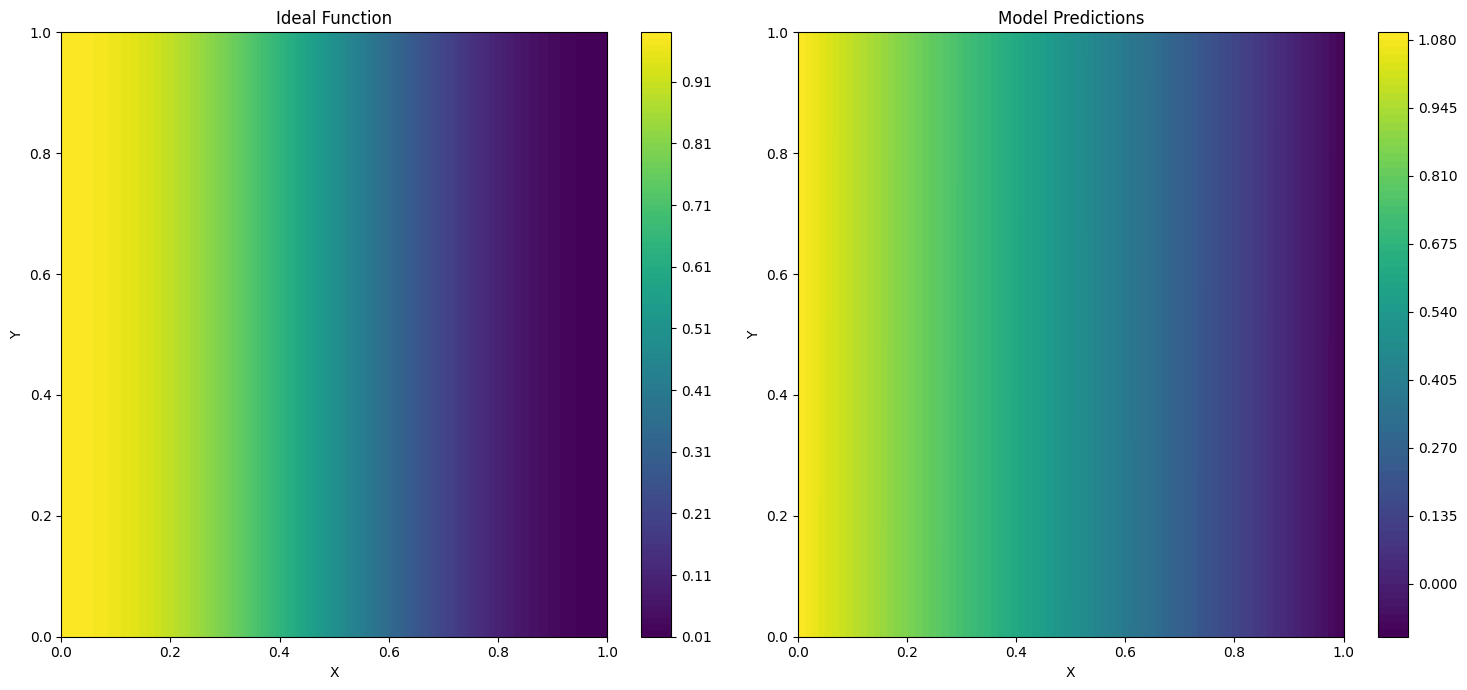

Training time: 24.25105934200019, mse: 0.0020867889876303005, r2: 0.9830817007661125


In [15]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(dataset, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.97e-01 | test loss: nan | reg: 2.31e+00 : 100%|███████| 50/50 [00:23<00:00,  2.14it/s]


Training time in seconds of lr=0.001: 23.397371504999683
Learning Rate: 0.001, Train MSE: 0.3591546159460697, Train r2: -1.9117871044104158


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.42e-01 | test loss: nan | reg: 6.46e+00 : 100%|███████| 50/50 [00:23<00:00,  2.16it/s]


Training time in seconds of lr=0.01: 23.118828263999603
Learning Rate: 0.01, Train MSE: 0.17678722924805956, Train r2: -0.4332734468495447


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:22<00:00,  2.18it/s]


Training time in seconds of lr=0.05: 22.977218438999444
Learning Rate: 0.05, Train MSE: 0.002077839072151237, Train r2: 0.9831542607370009


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.27e-02 | test loss: nan | reg: 1.18e+00 : 100%|███████| 50/50 [00:23<00:00,  2.16it/s]


Training time in seconds of lr=0.1: 23.100294063000547
Learning Rate: 0.1, Train MSE: 0.0021025958039763673, Train r2: 0.9829535495967977


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:24<00:00,  2.07it/s]


Training time in seconds of lr=0.2: 24.20073705300001
Learning Rate: 0.2, Train MSE: 0.0020894930393866944, Train r2: 0.9830597781102858


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.12e+00 : 100%|███████| 50/50 [00:23<00:00,  2.14it/s]


Training time in seconds of lr=0.5: 23.334930500000155
Learning Rate: 0.5, Train MSE: 0.002088880354977118, Train r2: 0.9830647453485828
Best Learning Rate: 0.05 with Train MSE: 0.002077839072151237


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.99e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:24<00:00,  2.08it/s]


Training time in seconds: 24.093118194000454
Layer 0 Bezier coefficients:
[[-0.5334489   0.38963902]
 [-0.05978779 -0.06102089]]
Layer 1 Bezier coefficients:
[[ 0.26861912 -0.24889094]]


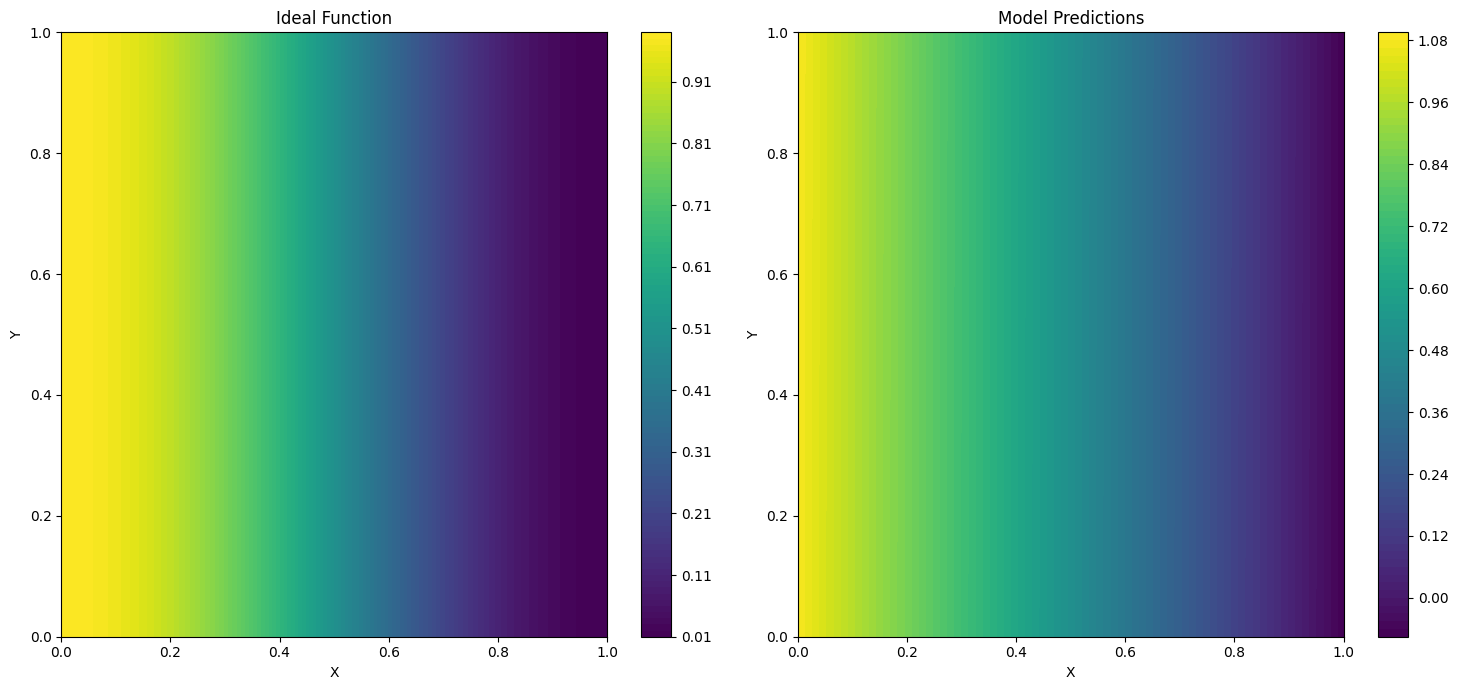

Training time: 24.093118194000454, mse: 0.0020775921291645858, r2: 0.983156262786737


In [16]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(dataset, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [17]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 4.542645613999249
MSE: 0.0027, r2: 0.9784
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 7.155537972999905
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 14.136212541999157
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 23.74489277399971
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 24.25105934200019
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 24.093118194000454
MSE: 0.0021, r2: 0.9832


# Now lets add a few more datapoints to make dataset 2

In [18]:
dataset_1 = dataset
X_1 = X
y_1 = 1
x_data_1 = x_data
y_data_1 = y_data
z_data_1 = z_data

In [19]:
dataset = dataset_split1
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [20]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file2, load_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [21]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.2887201149997054


In [22]:
# Combine datasets
combined_train_input = torch.cat((dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_2 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 172840.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 45.85 microseconds
qpu_access_time: 192067.62 microseconds
qpu_access_overhead_time: 1721.38 microseconds
qpu_programming_time: 19227.62 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 37.0 microseconds
total_post_processing_time: 37.0 microseconds

QPU Access Time: 192067.62 microseconds
Time spent on quantum annealer part 2: 0.19206762
Time spent on part 3: 0.000815786999737611
Time spent on optimization: 0.481603521999443
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.5, 1.0]
optimized_coefficients_3: [1.75, 1.0]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX

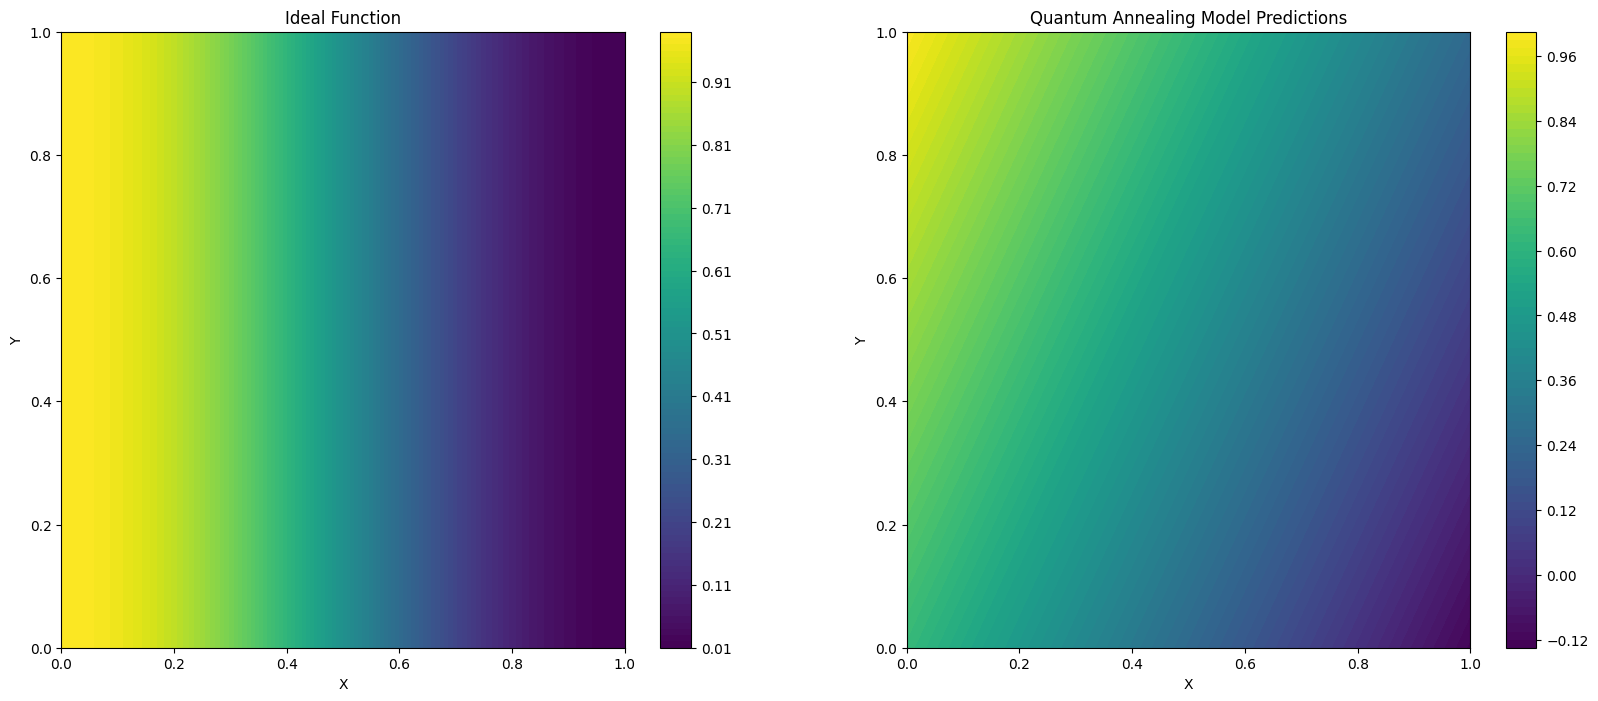

In [23]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 106348 microseconds
charge_time: 2988086 microseconds
run_time: 2988086 microseconds
problem_id: 08229897-1720-48fc-91eb-cb7f073545e4 microseconds

QPU Access Time: 106348 microseconds

Total D-Wave Run Time Including Setup: 2988086 microseconds
Time spent on hybrid part 2: 2.988086
Time spent on part 3: 0.0003977090000262251
Time spent on optimization: 3.2772038239997316
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.5, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: C

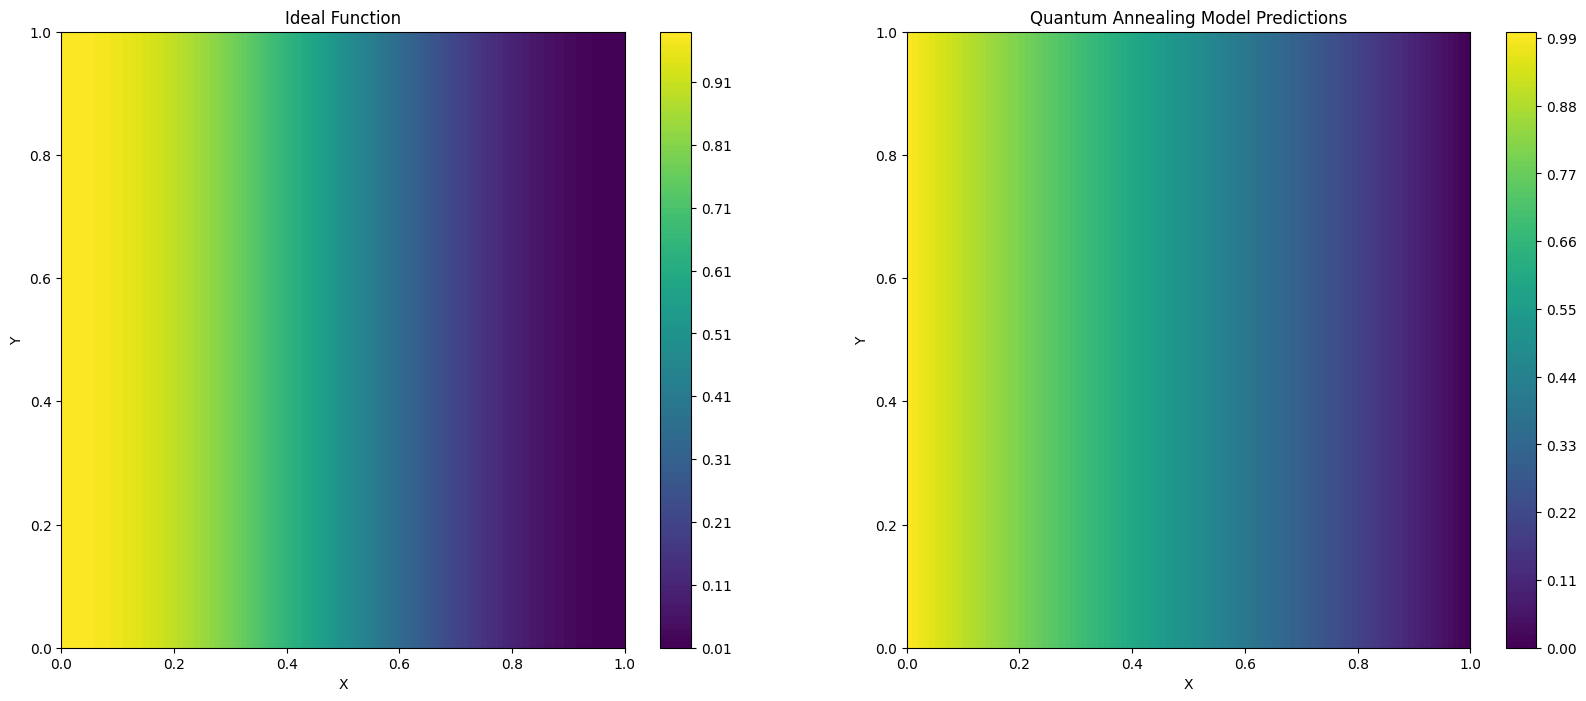

In [24]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.874227916000564
Time spent on part 3: 0.0013302360002853675
Time spent on optimization: 10.164278267000554
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.164278267000554, MSE: 0.0027, r2: 0.9784
time_part1: 0.2887201149997054, time_part2: 9.874227916000564, time_part3: 0.00133023

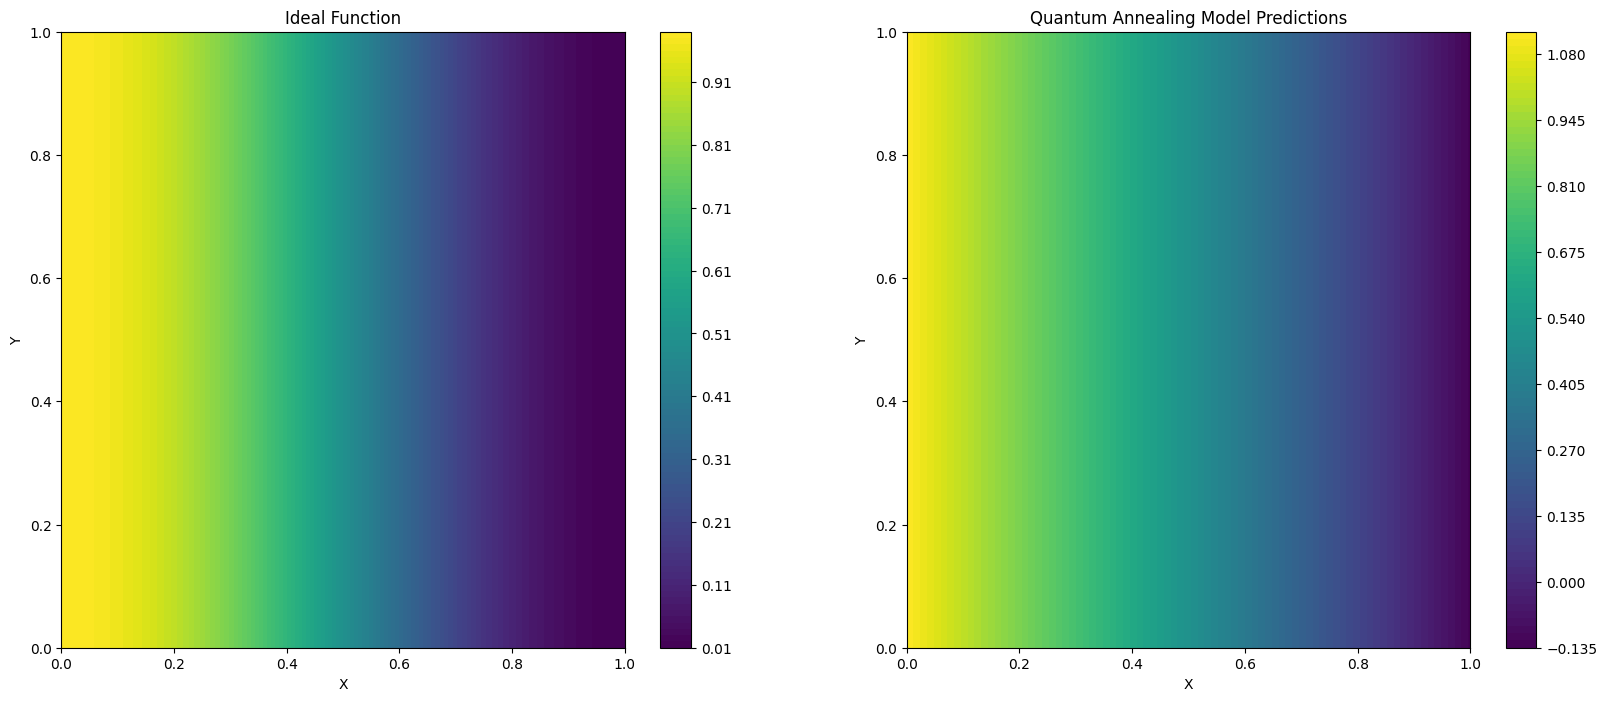

In [25]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]


Training time in seconds of lr=0.05: 25.35359070300001
Learning Rate: 0.05, Train MSE: 0.002148312335390784, Train r2: 0.9825829103213419


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.56e-02 | test loss: nan | reg: 1.30e+00 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]


Training time in seconds of lr=0.1: 25.327488443999755
Learning Rate: 0.1, Train MSE: 0.0024630572336262506, Train r2: 0.9800311677147576


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.31e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]


Training time in seconds of lr=0.2: 25.35352854699977
Learning Rate: 0.2, Train MSE: 0.0026176652205783133, Train r2: 0.9787777088347708
Best Learning Rate: 0.05 with Train MSE: 0.002148312335390784


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.52e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:25<00:00,  1.98it/s]


Training time in seconds: 25.218539382000017
Layer 0 Bezier coefficients:
[[-0.9534479   0.5615146 ]
 [ 0.09522659  0.09648741]]
Layer 1 Bezier coefficients:
[[ 0.37761694 -0.15921837]]


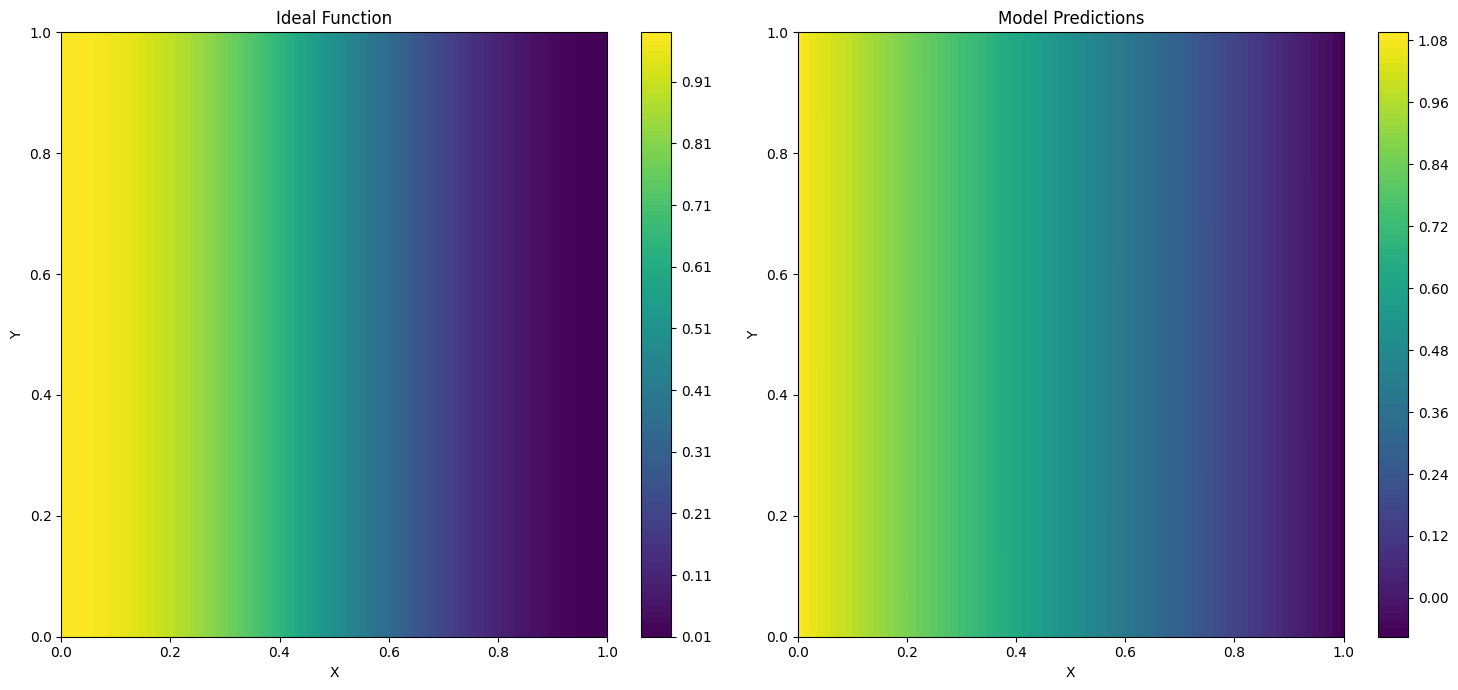

Training time: 25.218539382000017, mse: 0.002149144234460228, r2: 0.9825761658361675


In [26]:
learning_rates = [0.05, 0.1, 0.2]
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_2, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.29e+00 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]


Training time in seconds of lr=0.05: 25.44333600900063
Learning Rate: 0.05, Train MSE: 0.08154230899227476, Train r2: 0.3389091125499889


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.00e-01 | test loss: nan | reg: 1.28e+00 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]


Training time in seconds of lr=0.1: 25.366624439999214
Learning Rate: 0.1, Train MSE: 0.014436999797224462, Train r2: 0.882954393541064


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:25<00:00,  1.99it/s]


Training time in seconds of lr=0.2: 25.14519247899989
Learning Rate: 0.2, Train MSE: 0.0020864421394114897, Train r2: 0.9830845127811217
Best Learning Rate: 0.2 with Train MSE: 0.0020864421394114897


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:25<00:00,  1.98it/s]


Training time in seconds: 25.23914230599985
Layer 0 Bezier coefficients:
[[-0.42553154  0.5403781 ]
 [ 0.05549427  0.05464356]]
Layer 1 Bezier coefficients:
[[ 0.540592  -0.3376921]]


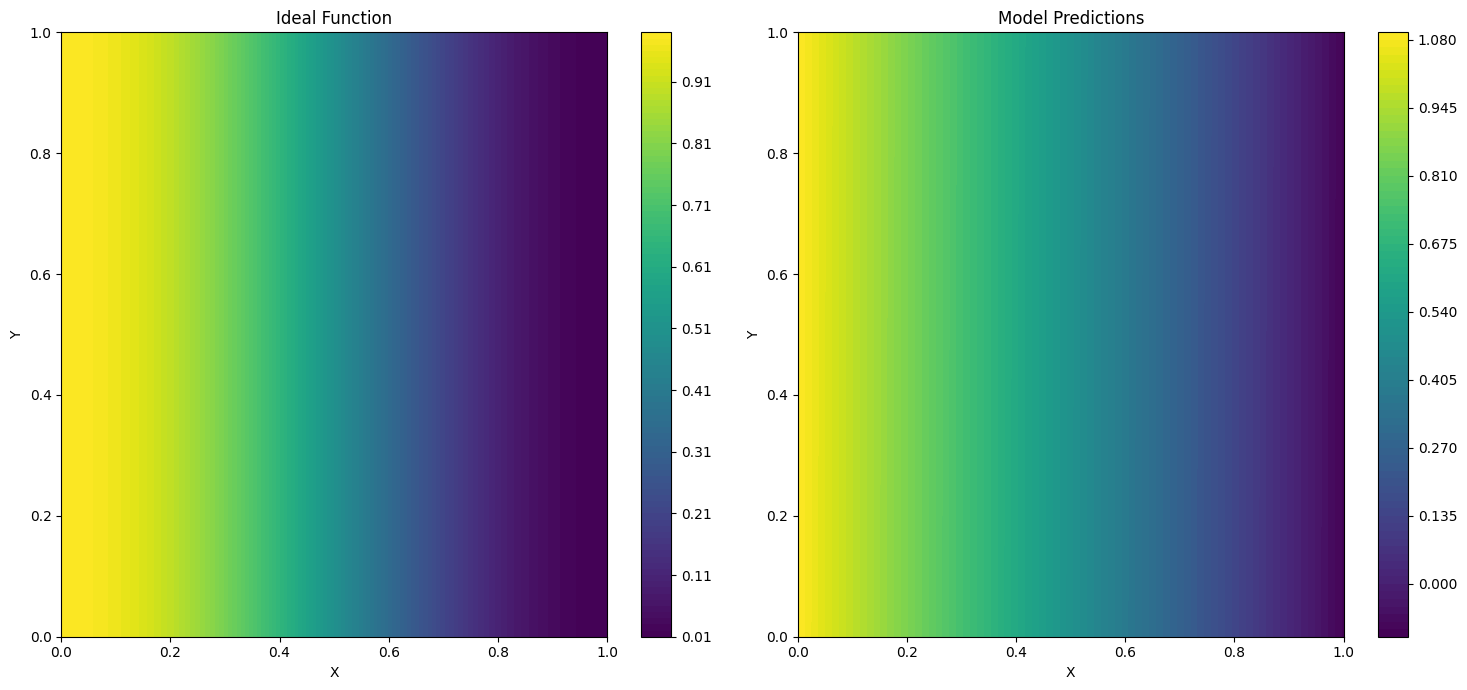

Training time: 25.23914230599985, mse: 0.0020864873600753724, r2: 0.983084146162011


In [27]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_2, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:25<00:00,  1.96it/s]


Training time in seconds of lr=0.05: 25.53303633700125
Learning Rate: 0.05, Train MSE: 0.0020783675564179887, Train r2: 0.983149976137543


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.28e-02 | test loss: nan | reg: 1.19e+00 : 100%|███████| 50/50 [00:25<00:00,  1.95it/s]


Training time in seconds of lr=0.1: 25.655695839001055
Learning Rate: 0.1, Train MSE: 0.002106649733393338, Train r2: 0.9829206830293796


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:25<00:00,  1.94it/s]


Training time in seconds of lr=0.2: 25.71224273700136
Learning Rate: 0.2, Train MSE: 0.002089391252329351, Train r2: 0.983060603332148
Best Learning Rate: 0.05 with Train MSE: 0.0020783675564179887


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:25<00:00,  1.94it/s]


Training time in seconds: 25.7922243539997
Layer 0 Bezier coefficients:
[[-0.5334497   0.38959995]
 [-0.05920419 -0.06061548]]
Layer 1 Bezier coefficients:
[[ 0.26898822 -0.2486837 ]]


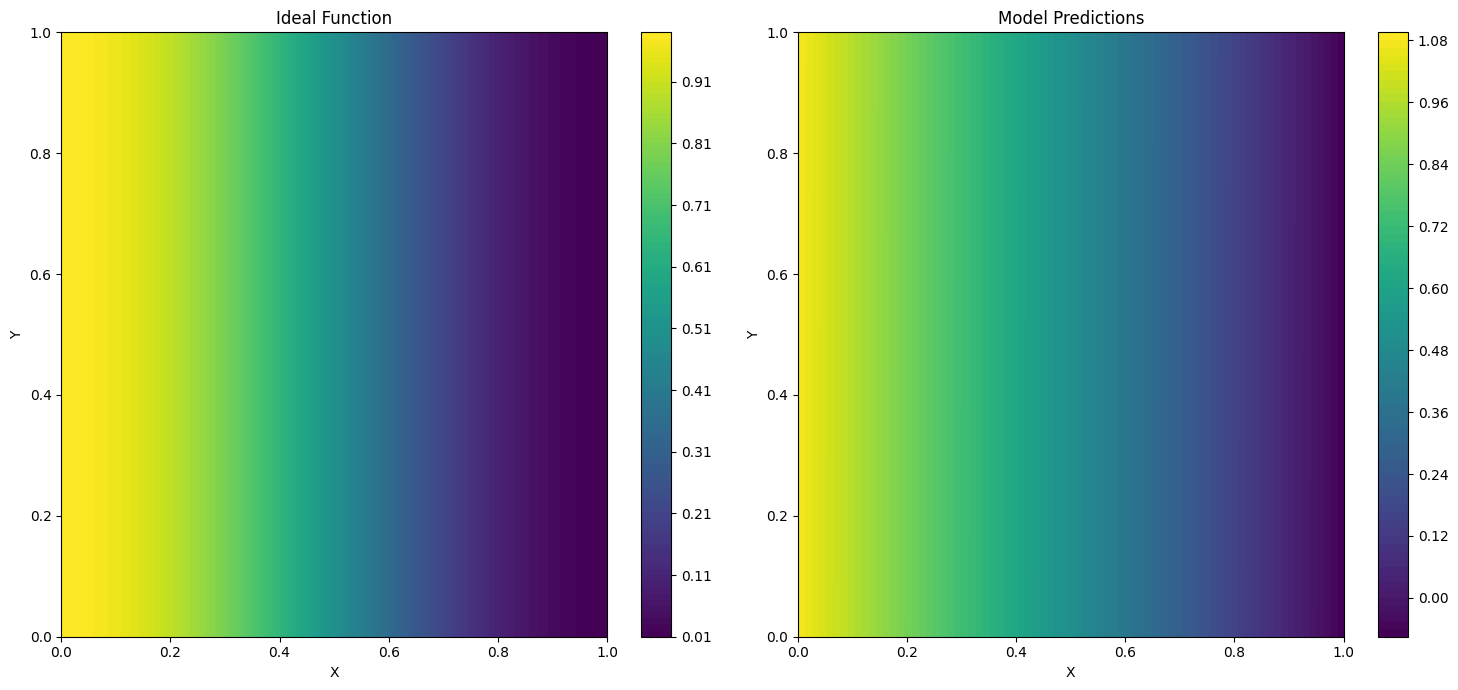

Training time: 25.7922243539997, mse: 0.0020781390937511055, r2: 0.9831518283611195


In [28]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_2, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [29]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.481603521999443
MSE: 0.0340, r2: 0.7246
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.2772038239997316
MSE: 0.0045, r2: 0.9633
Simulated Annealing Metrics
Total run time in seconds: 10.164278267000554
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 25.218539382000017
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 25.23914230599985
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 25.7922243539997
MSE: 0.0021, r2: 0.9832
Array of time for quantum in each training/retraining: [4.542645613999249, 0.481603521999443], total time: 5.0242491359986925
Array of time for hybrid in each training/retraining: [7.155537972999905, 3.2772038239997316], total time: 10.432741796999636
Array of time for simulated in each training/retraining: [14.136212541999157, 10.164278267000554], total time: 24.30049080899971
Array of time for adam in each training/ret

# Adding a few more datapoints to make dataset 3

In [30]:
dataset_2 = dataset
X_2 = X
y_2 = 1
x_data_2 = x_data
y_data_2 = y_data
z_data_2 = z_data

In [31]:
dataset = dataset_split2
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [32]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file3, load_filename=save_file2
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [33]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.2887695099998382


In [34]:
# Combine datasets
combined_train_input = torch.cat((dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_3 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 238040.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 78.45 microseconds
qpu_access_time: 257267.22 microseconds
qpu_access_overhead_time: 2532.78 microseconds
qpu_programming_time: 19227.22 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 13.0 microseconds
total_post_processing_time: 13.0 microseconds

QPU Access Time: 257267.22 microseconds
Time spent on quantum annealer part 2: 0.25726721999999996
Time spent on part 3: 0.0007809239996277029
Time spent on optimization: 0.5468176539994658
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.5, 0.5]
optimized_coefficients_3: [1.5, 0.75]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: 

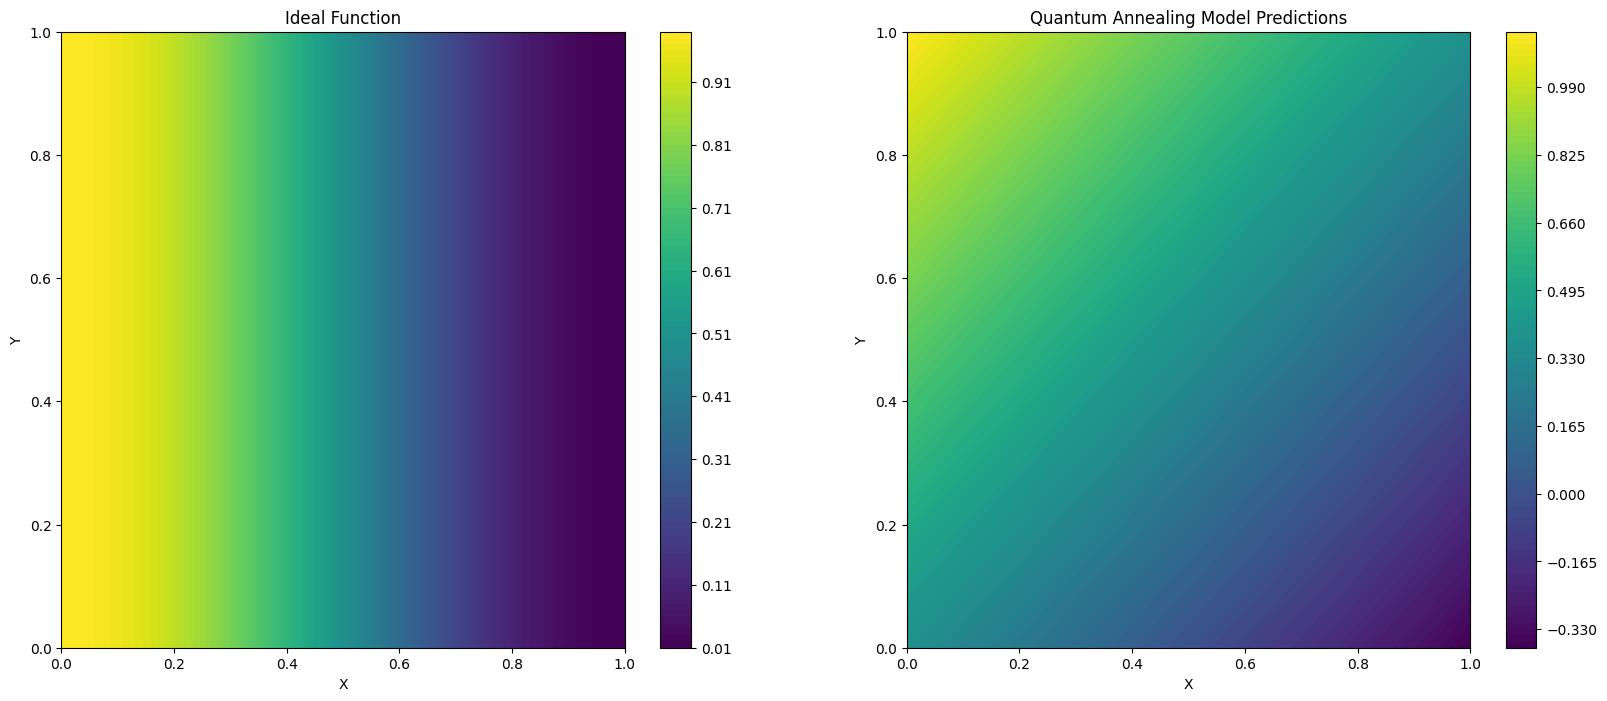

In [35]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 184373 microseconds
charge_time: 3000000 microseconds
run_time: 3000054 microseconds
problem_id: 8e2502f9-887c-424d-a6d0-1405013ed392 microseconds

QPU Access Time: 184373 microseconds

Total D-Wave Run Time Including Setup: 3000054 microseconds
Time spent on hybrid part 2: 3.000054
Time spent on part 3: 0.00040910700045060366
Time spent on optimization: 3.289232617000289
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: 

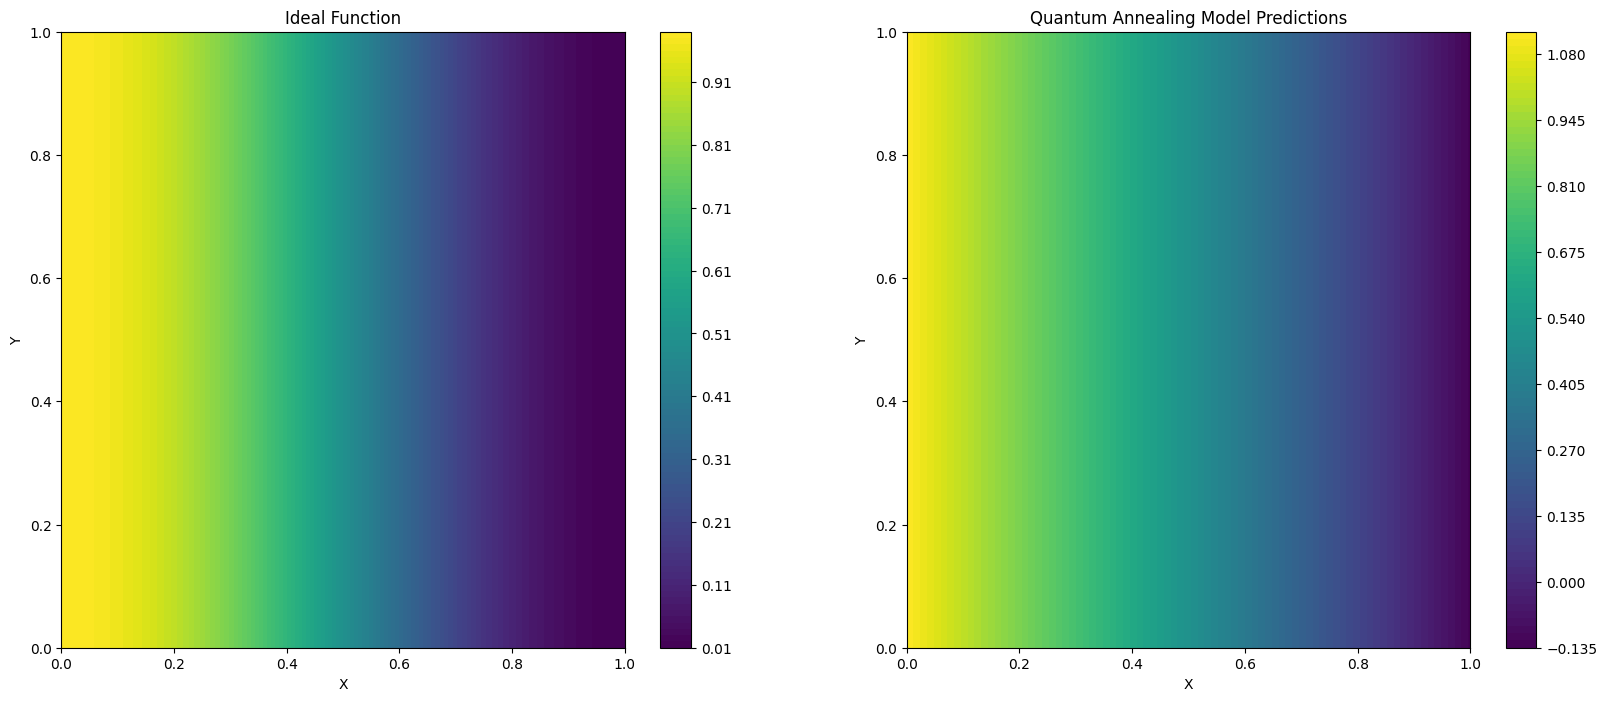

In [36]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.940595718000623
Time spent on part 3: 0.0013008669993723743
Time spent on optimization: 10.230666094999833
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.230666094999833, MSE: 0.0027, r2: 0.9784
time_part1: 0.2887695099998382, time_part2: 9.940595718000623, time_part3: 0.00130086

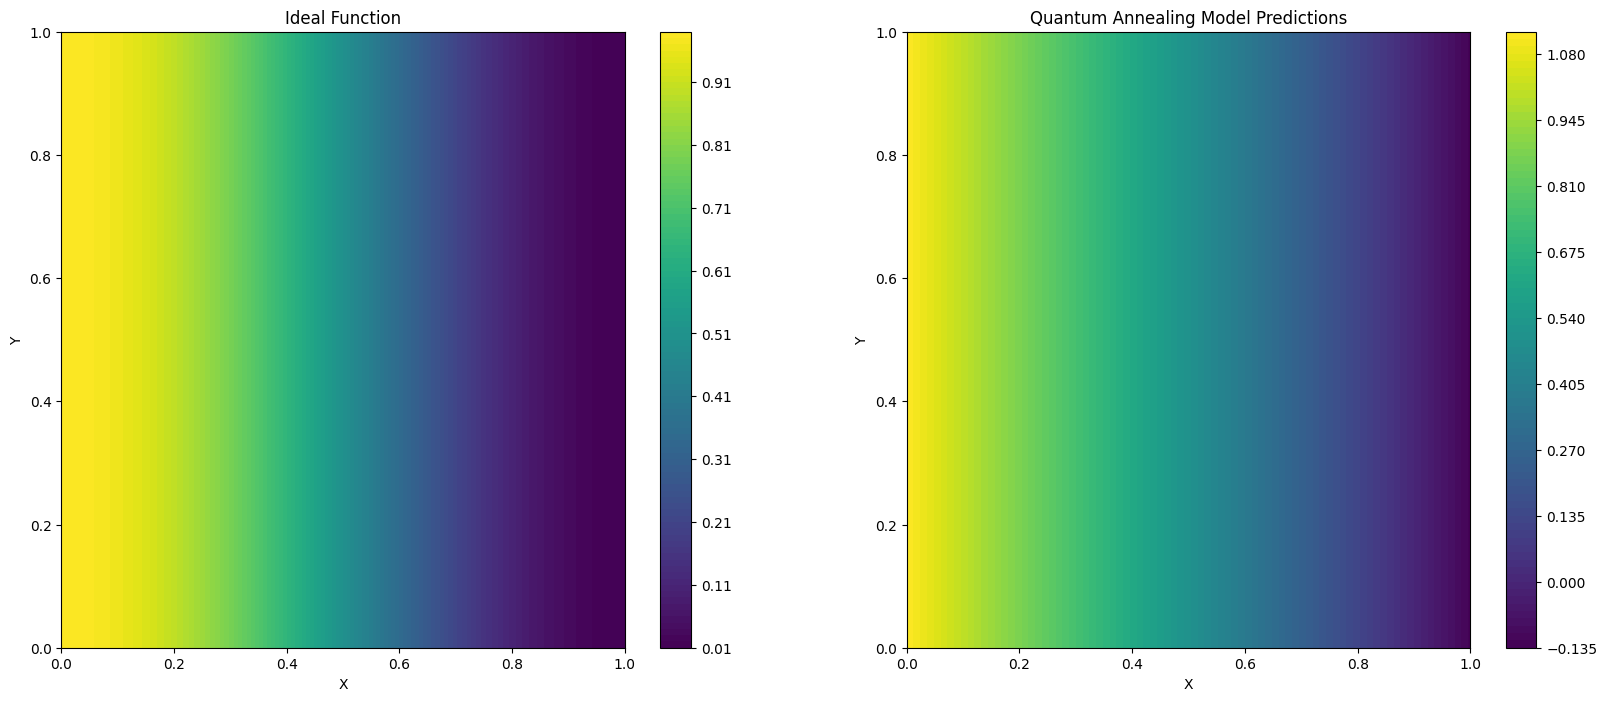

In [37]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:27<00:00,  1.79it/s]


Training time in seconds of lr=0.05: 27.904598658000396
Learning Rate: 0.05, Train MSE: 0.0021488689851689685, Train r2: 0.9825783973746225


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.55e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:28<00:00,  1.77it/s]


Training time in seconds of lr=0.1: 28.262352781999653
Learning Rate: 0.1, Train MSE: 0.002444006193454712, Train r2: 0.980185620896296


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.34e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:29<00:00,  1.70it/s]


Training time in seconds of lr=0.2: 29.452007744001094
Learning Rate: 0.2, Train MSE: 0.0026009914724255128, Train r2: 0.9789128885114279
Best Learning Rate: 0.05 with Train MSE: 0.0021488689851689685


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.55e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:27<00:00,  1.80it/s]


Training time in seconds: 27.717337407999366
Layer 0 Bezier coefficients:
[[-0.9525594   0.56212866]
 [ 0.09553863  0.09665389]]
Layer 1 Bezier coefficients:
[[ 0.3781481 -0.1591885]]


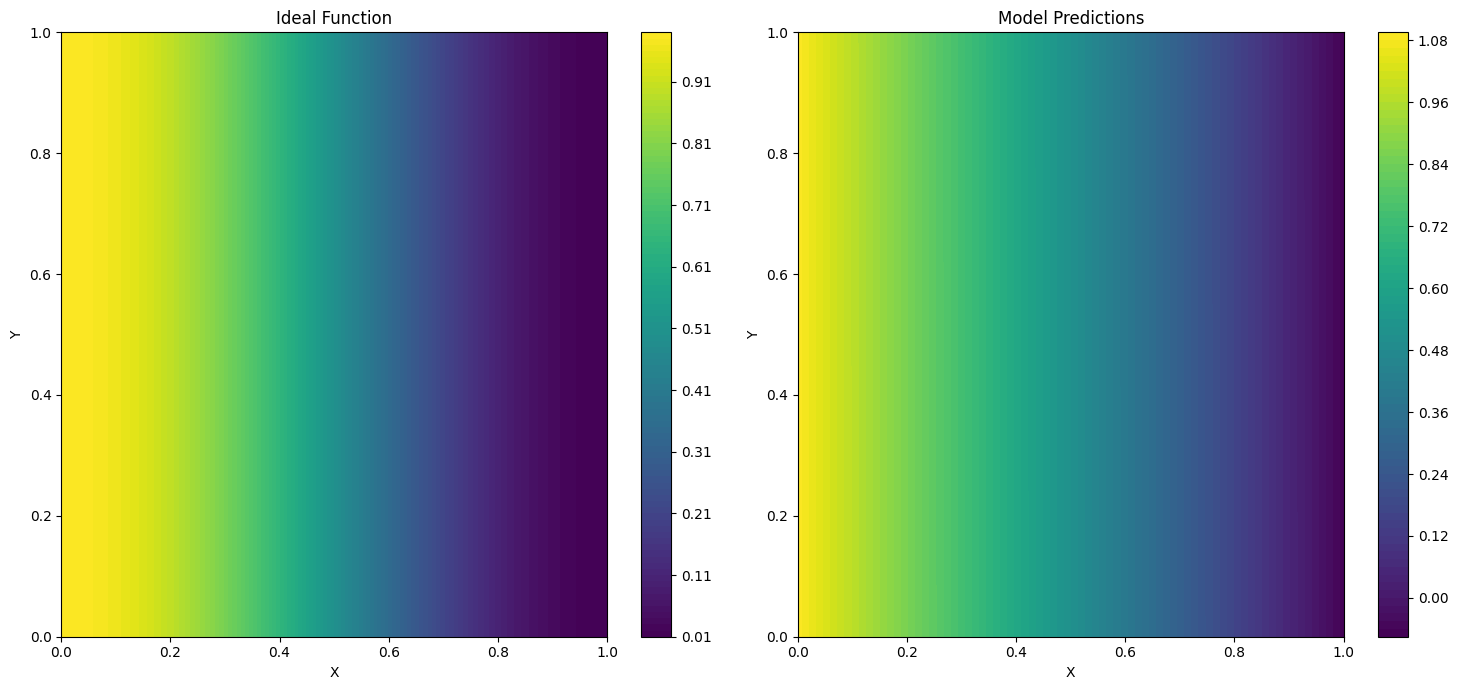

Training time: 27.717337407999366, mse: 0.002144851733354024, r2: 0.9826109665844017


In [38]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_3, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.28e+00 : 100%|███████| 50/50 [00:28<00:00,  1.76it/s]


Training time in seconds of lr=0.05: 28.383713806000742
Learning Rate: 0.05, Train MSE: 0.08153340023721585, Train r2: 0.3389813388195262


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.10e-01 | test loss: nan | reg: 1.27e+00 : 100%|███████| 50/50 [00:28<00:00,  1.77it/s]


Training time in seconds of lr=0.1: 28.26262979600142
Learning Rate: 0.1, Train MSE: 0.017321796696157084, Train r2: 0.8595663761351663


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:28<00:00,  1.74it/s]


Training time in seconds of lr=0.2: 28.760046883999166
Learning Rate: 0.2, Train MSE: 0.002085670805202976, Train r2: 0.9830907662466262
Best Learning Rate: 0.2 with Train MSE: 0.002085670805202976


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:29<00:00,  1.71it/s]


Training time in seconds: 29.1936900590008
Layer 0 Bezier coefficients:
[[-0.43028113  0.5577221 ]
 [ 0.06091066  0.05981357]]
Layer 1 Bezier coefficients:
[[ 0.5503899 -0.3037978]]


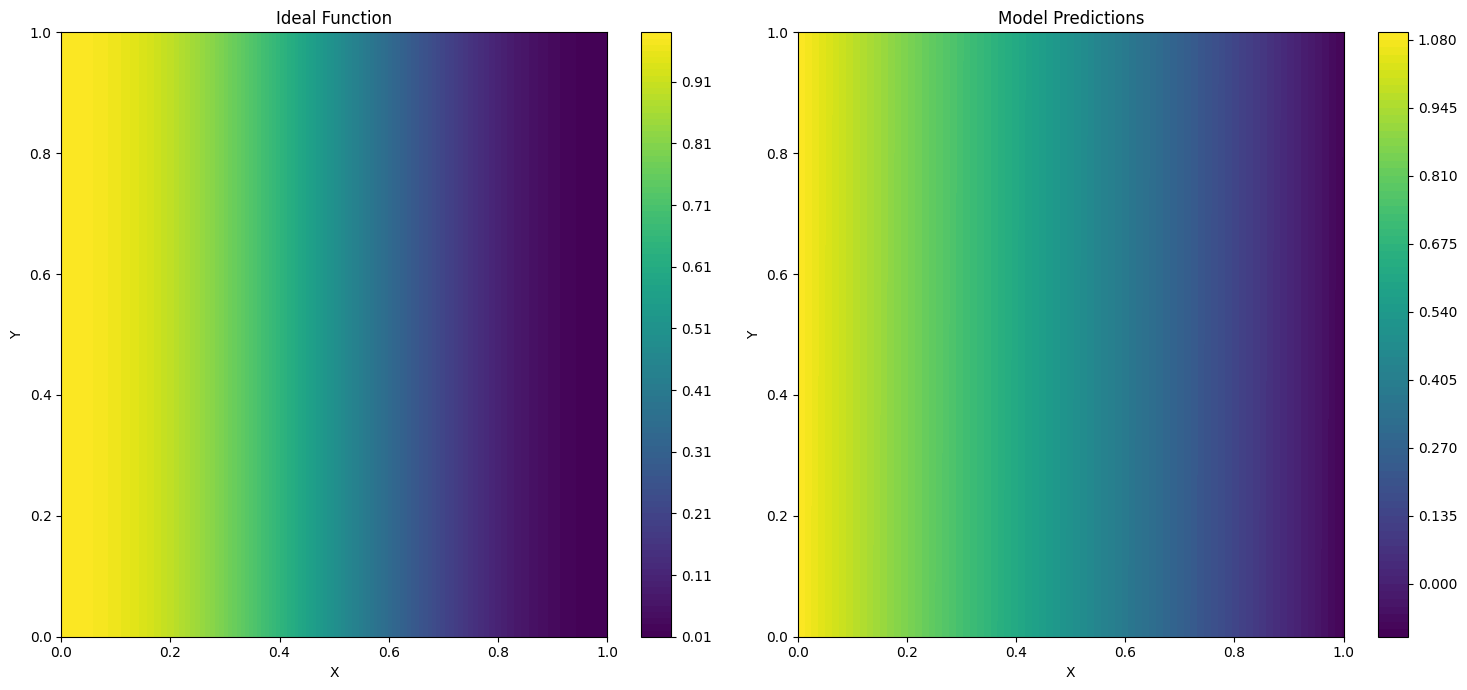

Training time: 29.1936900590008, mse: 0.0020856771130727124, r2: 0.9830907151066075


In [39]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_3, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:28<00:00,  1.75it/s]


Training time in seconds of lr=0.05: 28.655893864000973
Learning Rate: 0.05, Train MSE: 0.0020779628896384714, Train r2: 0.983153256907044


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:28<00:00,  1.75it/s]


Training time in seconds of lr=0.1: 28.53892108999935
Learning Rate: 0.1, Train MSE: 0.002088342706690574, Train r2: 0.9830691042438273


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:28<00:00,  1.76it/s]


Training time in seconds of lr=0.2: 28.353373552001358
Learning Rate: 0.2, Train MSE: 0.0020890102918665336, Train r2: 0.983063691906577
Best Learning Rate: 0.05 with Train MSE: 0.0020779628896384714


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:28<00:00,  1.78it/s]


Training time in seconds: 28.037087189000886
Layer 0 Bezier coefficients:
[[-0.53398573  0.38954625]
 [-0.05918584 -0.06062615]]
Layer 1 Bezier coefficients:
[[ 0.2687433  -0.24877323]]


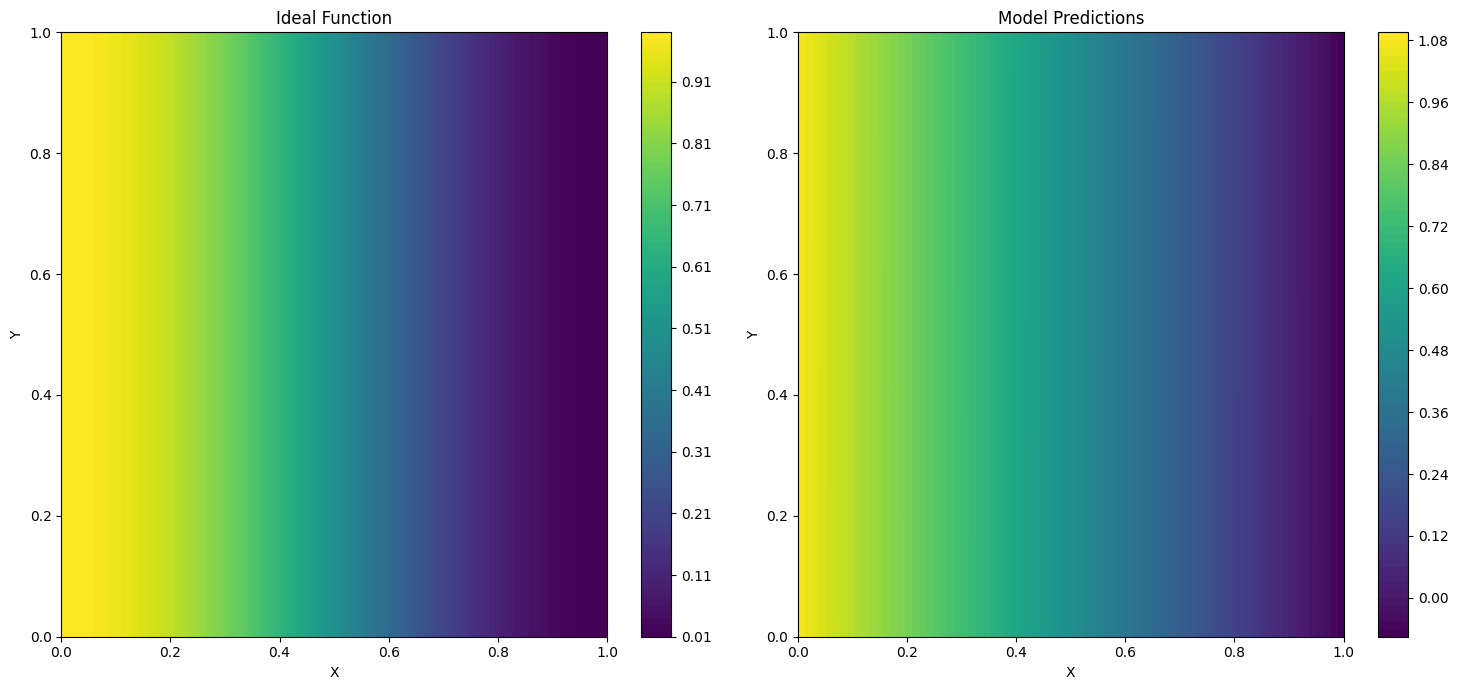

Training time: 28.037087189000886, mse: 0.0020774931564398118, r2: 0.9831570651918596


In [40]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_3, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [41]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.5468176539994658
MSE: 0.0833, r2: 0.3250
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.289232617000289
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.230666094999833
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 27.717337407999366
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 29.1936900590008
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 28.037087189000886
MSE: 0.0021, r2: 0.9832
Array of time for quantum in each training/retraining: [4.542645613999249, 0.481603521999443, 0.5468176539994658], total time: 5.5710667899981585
Array of time for hybrid in each training/retraining: [7.155537972999905, 3.2772038239997316, 3.289232617000289], total time: 13.721974413999925
Array of time for simulated in each training/retraining: [14.136212541999157, 10.164278267000554, 10.230666094999833], total time: 3

# Adding a few more datapoints for dataset 4

In [42]:
dataset_3 = dataset
X_3 = X
y_3 = 1
x_data_3 = x_data
y_data_3 = y_data
z_data_3 = z_data

In [43]:
dataset = dataset_split3
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [44]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file4, load_filename=save_file3
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [45]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.28245700700063026


In [46]:
# Combine datasets
combined_train_input = torch.cat((dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_4 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 226680.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 72.77 microseconds
qpu_access_time: 245907.62 microseconds
qpu_access_overhead_time: 2875.38 microseconds
qpu_programming_time: 19227.62 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 1.0 microseconds
total_post_processing_time: 1.0 microseconds

QPU Access Time: 245907.62 microseconds
Time spent on quantum annealer part 2: 0.24590762
Time spent on part 3: 0.0004460000000108266
Time spent on optimization: 0.5288106270006411
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 1.0]
optimized_coefficients_3: [1.75, 0.75]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AU

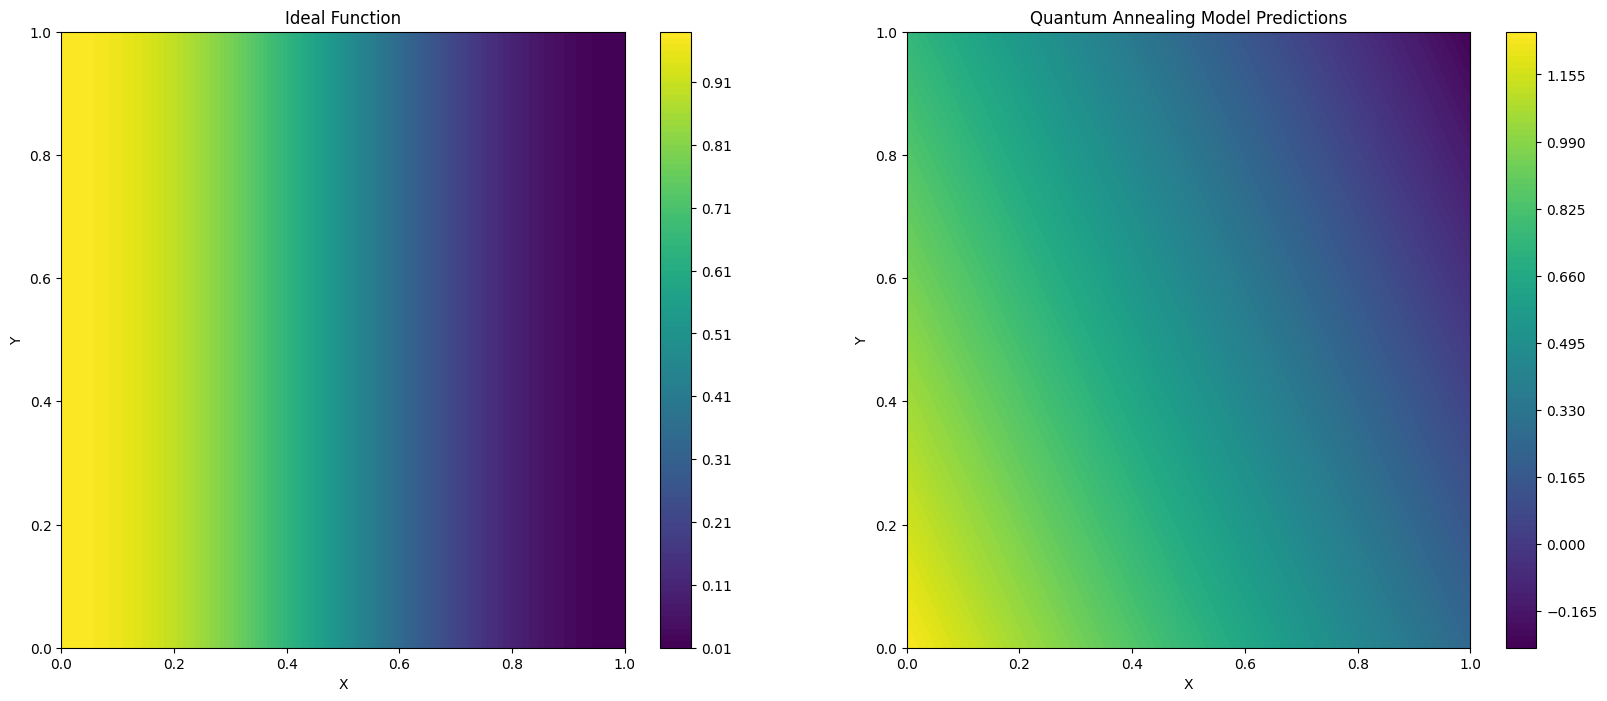

In [47]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 132743 microseconds
charge_time: 2984980 microseconds
run_time: 2984980 microseconds
problem_id: 4dc17493-f1c6-420f-8c35-472cd96f391f microseconds

QPU Access Time: 132743 microseconds

Total D-Wave Run Time Including Setup: 2984980 microseconds
Time spent on hybrid part 2: 2.9849799999999997
Time spent on part 3: 0.00042794399996637367
Time spent on optimization: 3.2678649510005964
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.5, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Corre

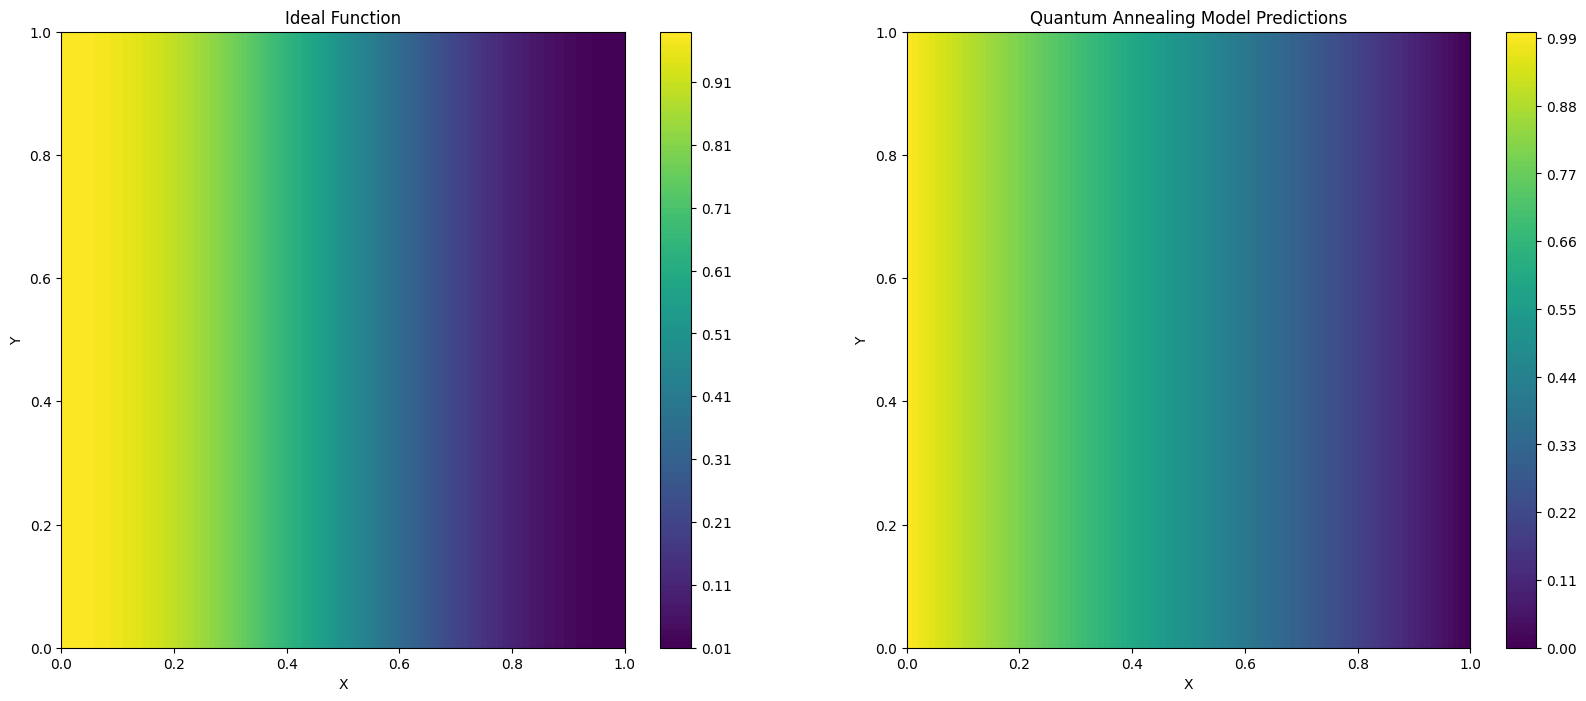

In [48]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.881200155001352
Time spent on part 3: 0.0013452700004563667
Time spent on optimization: 10.165002432002439
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.165002432002439, MSE: 0.0027, r2: 0.9784
time_part1: 0.28245700700063026, time_part2: 9.881200155001352, time_part3: 0.0013452

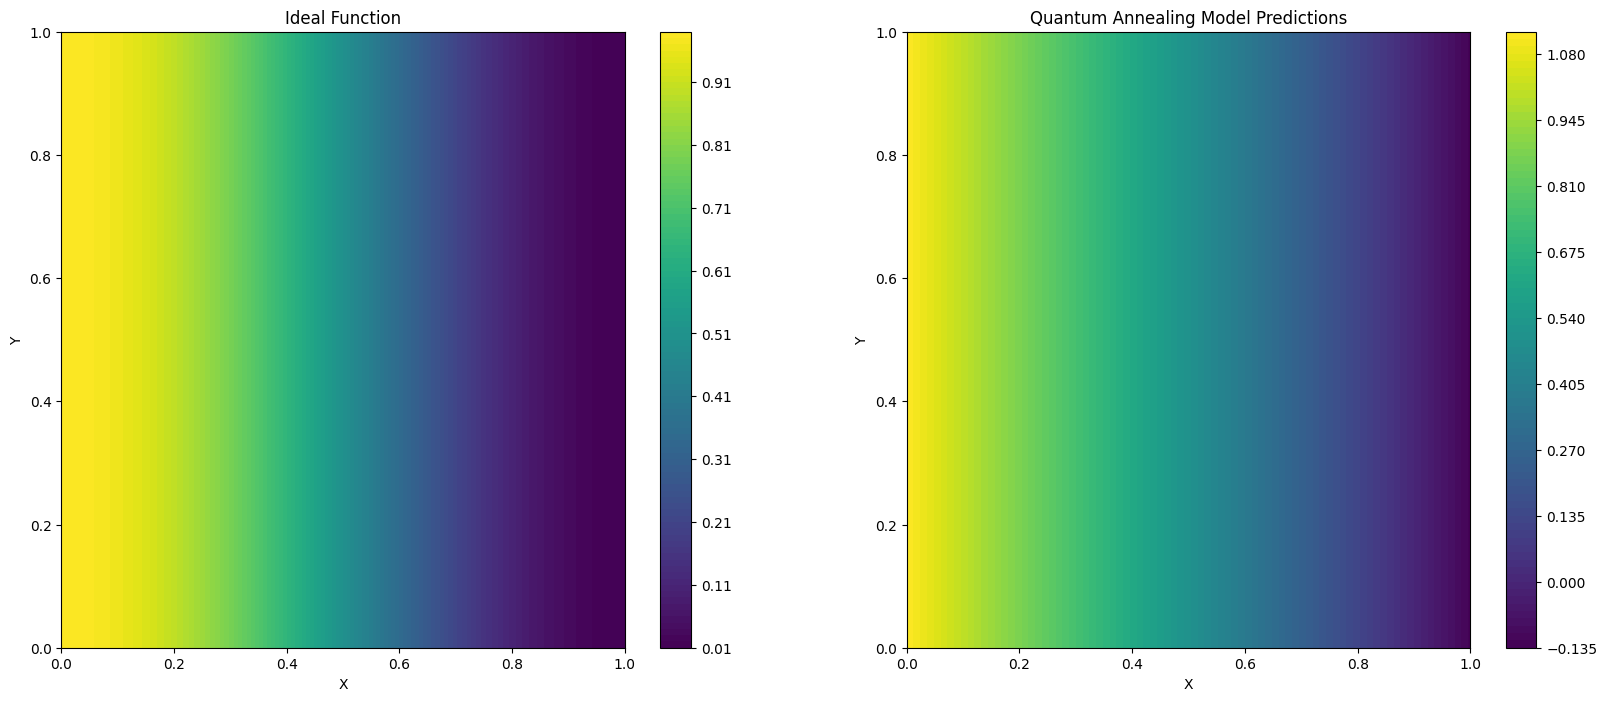

In [49]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.55e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:30<00:00,  1.64it/s]


Training time in seconds of lr=0.05: 30.477338808999775
Learning Rate: 0.05, Train MSE: 0.002150514573347004, Train r2: 0.9825650560385426


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.57e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:30<00:00,  1.63it/s]


Training time in seconds of lr=0.1: 30.679888107000806
Learning Rate: 0.1, Train MSE: 0.0024727651362480775, Train r2: 0.9799524624875099


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.27e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:31<00:00,  1.61it/s]


Training time in seconds of lr=0.2: 31.03630978199908
Learning Rate: 0.2, Train MSE: 0.002569215592027003, Train r2: 0.9791705062467086
Best Learning Rate: 0.05 with Train MSE: 0.002150514573347004


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.54e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:30<00:00,  1.62it/s]


Training time in seconds: 30.88551136500064
Layer 0 Bezier coefficients:
[[-0.95229214  0.56205136]
 [ 0.09500076  0.09614525]]
Layer 1 Bezier coefficients:
[[ 0.37808782 -0.15928227]]


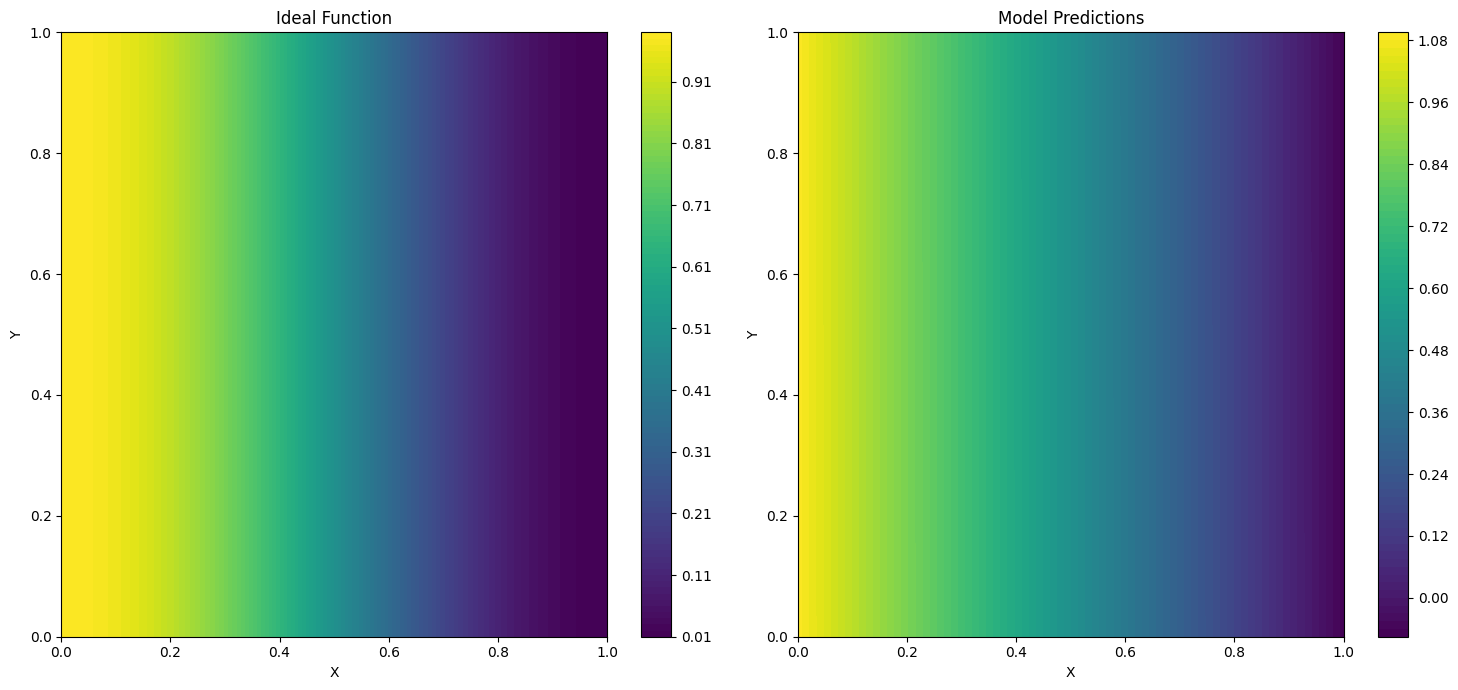

Training time: 30.88551136500064, mse: 0.0021476018471840584, r2: 0.9825886704878728


In [50]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_4, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.27e+00 : 100%|███████| 50/50 [00:30<00:00,  1.62it/s]


Training time in seconds of lr=0.05: 30.9003622909986
Learning Rate: 0.05, Train MSE: 0.08144674056738542, Train r2: 0.33968391787011143


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.09e-01 | test loss: nan | reg: 1.30e+00 : 100%|███████| 50/50 [00:30<00:00,  1.64it/s]


Training time in seconds of lr=0.1: 30.58362955499979
Learning Rate: 0.1, Train MSE: 0.017207250381649296, Train r2: 0.8604950415807237


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.07e+00 : 100%|███████| 50/50 [00:30<00:00,  1.64it/s]


Training time in seconds of lr=0.2: 30.456424977001006
Learning Rate: 0.2, Train MSE: 0.0020855058979128496, Train r2: 0.9830921032054163
Best Learning Rate: 0.2 with Train MSE: 0.0020855058979128496


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:30<00:00,  1.63it/s]


Training time in seconds: 30.625205116999496
Layer 0 Bezier coefficients:
[[-0.43097824  0.557538  ]
 [ 0.06096871  0.05984982]]
Layer 1 Bezier coefficients:
[[ 0.5499332  -0.30381298]]


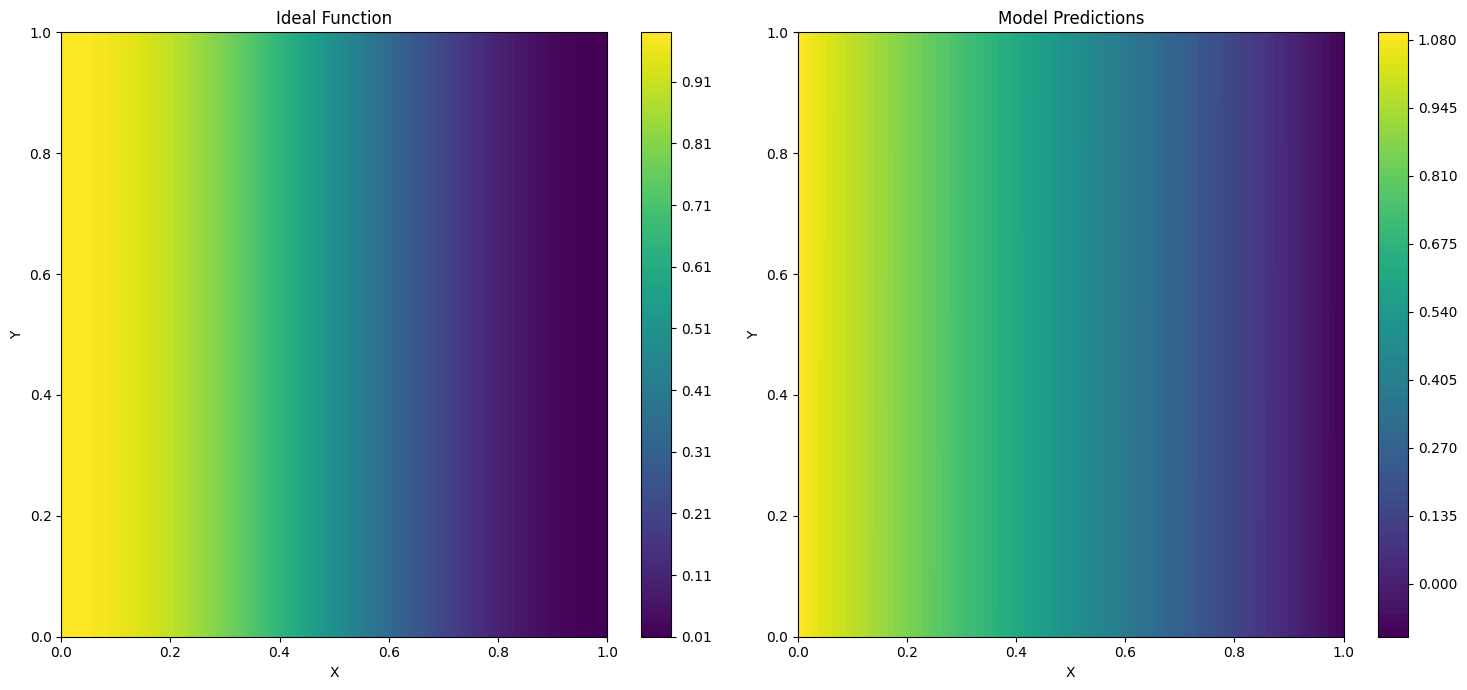

Training time: 30.625205116999496, mse: 0.002085478431213568, r2: 0.9830923258871729


In [51]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_4, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.81e-02 | test loss: nan | reg: 2.03e+00 : 100%|███████| 50/50 [00:30<00:00,  1.66it/s]


Training time in seconds of lr=0.05: 30.204123580999294
Learning Rate: 0.05, Train MSE: 0.0021350940165177903, Train r2: 0.9826900756722172


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:29<00:00,  1.67it/s]


Training time in seconds of lr=0.1: 29.9341381560007
Learning Rate: 0.1, Train MSE: 0.0020876324379656935, Train r2: 0.9830748626309451


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:29<00:00,  1.67it/s]


Training time in seconds of lr=0.2: 29.91648499599978
Learning Rate: 0.2, Train MSE: 0.002089507639881929, Train r2: 0.983059659739167
Best Learning Rate: 0.1 with Train MSE: 0.0020876324379656935


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:30<00:00,  1.66it/s]


Training time in seconds: 30.17753189799987
Layer 0 Bezier coefficients:
[[-0.63328445  0.33408675]
 [ 0.05443347  0.05443664]]
Layer 1 Bezier coefficients:
[[ 0.25881773 -0.23924276]]


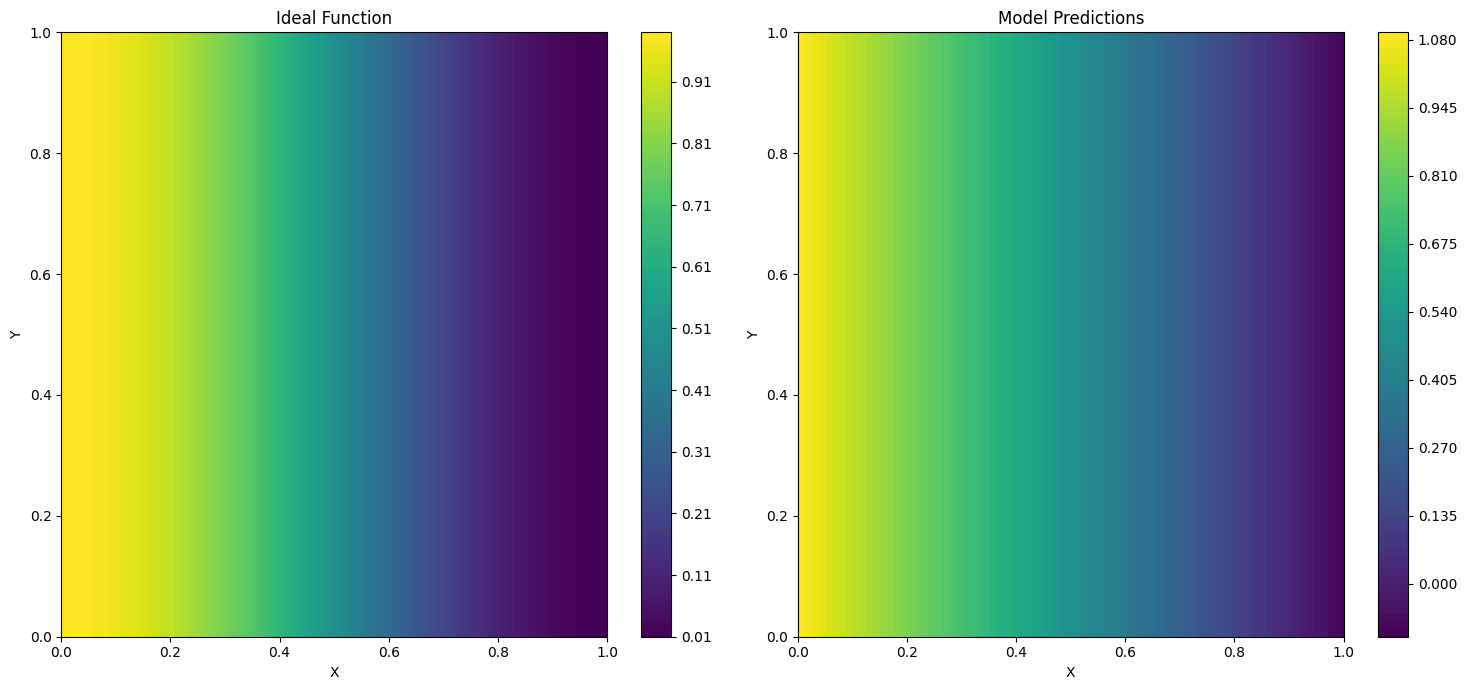

Training time: 30.17753189799987, mse: 0.00208822661569983, r2: 0.9830700454324819


In [52]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_4, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [53]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.5288106270006411
MSE: 0.0268, r2: 0.7827
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.2678649510005964
MSE: 0.0045, r2: 0.9633
Simulated Annealing Metrics
Total run time in seconds: 10.165002432002439
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 30.88551136500064
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 30.625205116999496
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 30.17753189799987
MSE: 0.0021, r2: 0.9831
Array of time for quantum in each training/retraining: [4.542645613999249, 0.481603521999443, 0.5468176539994658, 0.5288106270006411], total time: 6.099877416998799
Array of time for hybrid in each training/retraining: [7.155537972999905, 3.2772038239997316, 3.289232617000289, 3.2678649510005964], total time: 16.98983936500052
Array of time for simulated in each training/retraining: [14.136212541999157, 10.164278267000

# Adding a few more datapoints for dataset 5

In [54]:
dataset_4 = dataset
X_4 = X
y_4 = 1
x_data_4 = x_data
y_data_4 = y_data
z_data_4 = z_data

In [55]:
dataset = dataset_split4
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [56]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    load_filename=save_file4
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [57]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.2889787019994401


In [58]:
# Combine datasets
combined_train_input = torch.cat((dataset_4['train_input'], dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_4['test_input'], dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_4['test_label'], dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_5 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 239240.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 79.05 microseconds
qpu_access_time: 258468.02 microseconds
qpu_access_overhead_time: 2711.98 microseconds
qpu_programming_time: 19228.02 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 1.0 microseconds
total_post_processing_time: 1.0 microseconds

QPU Access Time: 258468.02 microseconds
Time spent on quantum annealer part 2: 0.25846801999999997
Time spent on part 3: 0.0007742380003037397
Time spent on optimization: 0.5482209599997439
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.5, 1.0]
optimized_coefficients_3: [1.75, 1.0]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Co

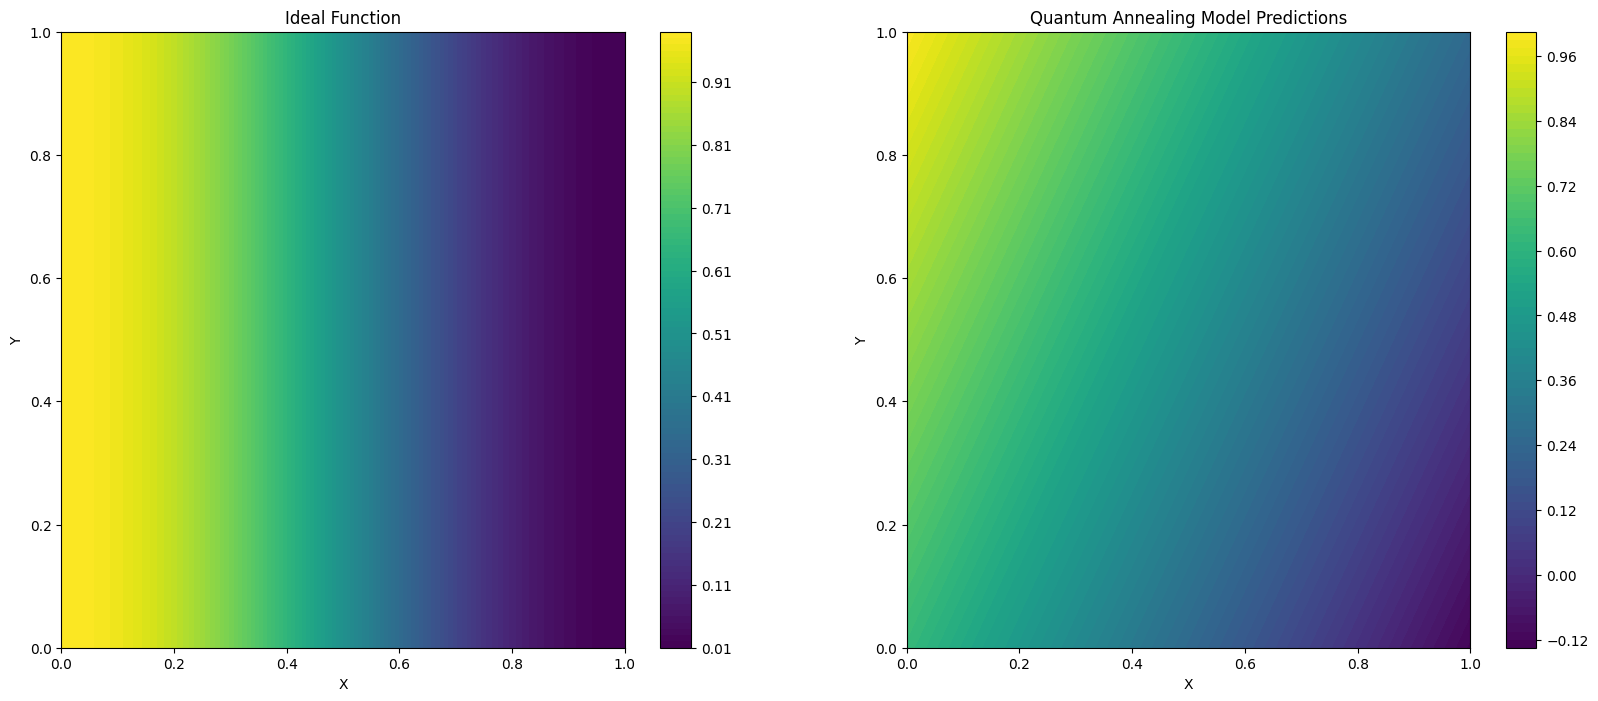

In [59]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 183313 microseconds
charge_time: 2984287 microseconds
run_time: 2984287 microseconds
problem_id: 29398f57-aa90-4e26-9590-efaa631eb618 microseconds

QPU Access Time: 183313 microseconds

Total D-Wave Run Time Including Setup: 2984287 microseconds
Time spent on hybrid part 2: 2.9842869999999997
Time spent on part 3: 0.00042513300104474183
Time spent on optimization: 3.2736908350004845
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Corr

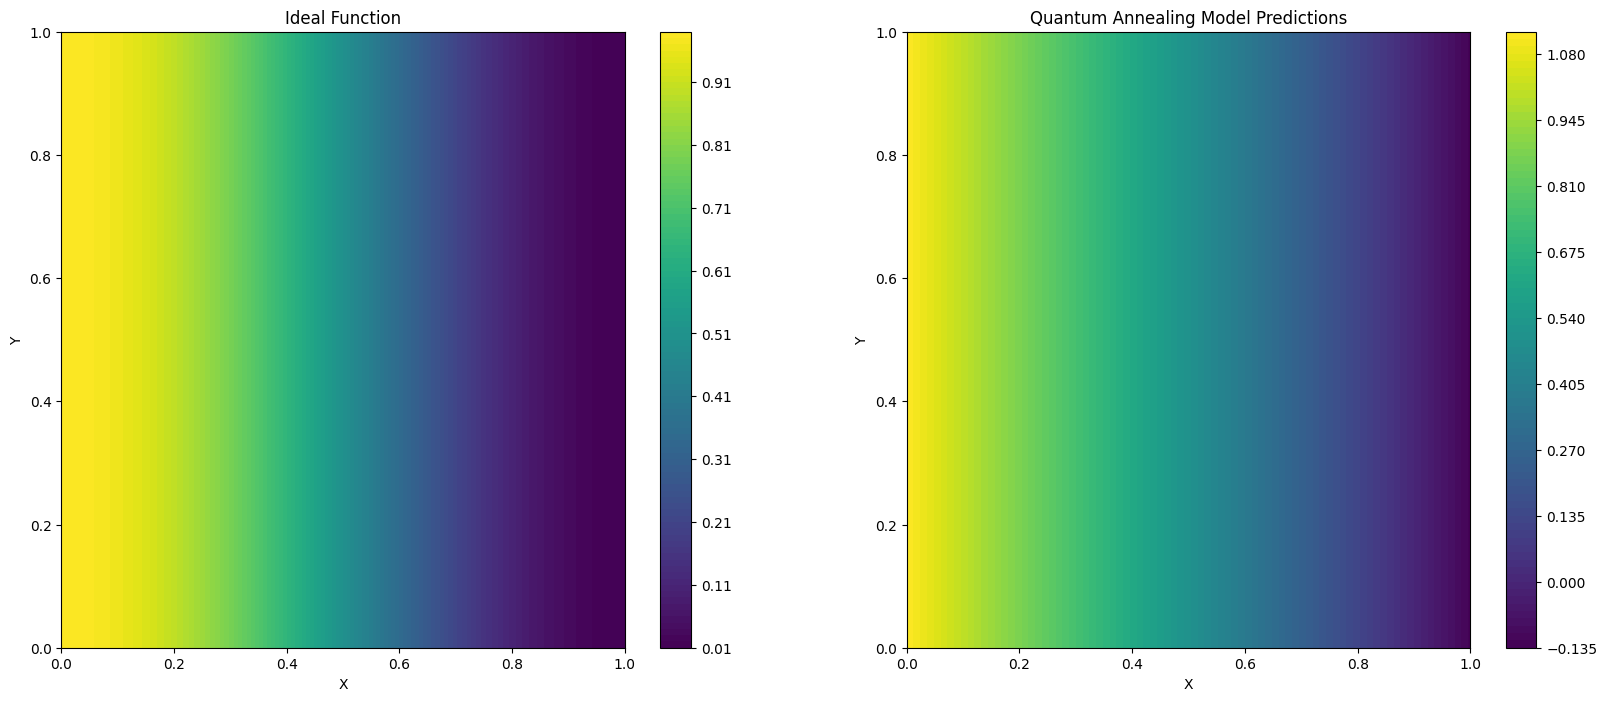

In [60]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.935126829999717
Time spent on part 3: 0.001435471000149846
Time spent on optimization: 10.225541002999307
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.225541002999307, MSE: 0.0027, r2: 0.9784
time_part1: 0.2889787019994401, time_part2: 9.935126829999717, time_part3: 0.001435471

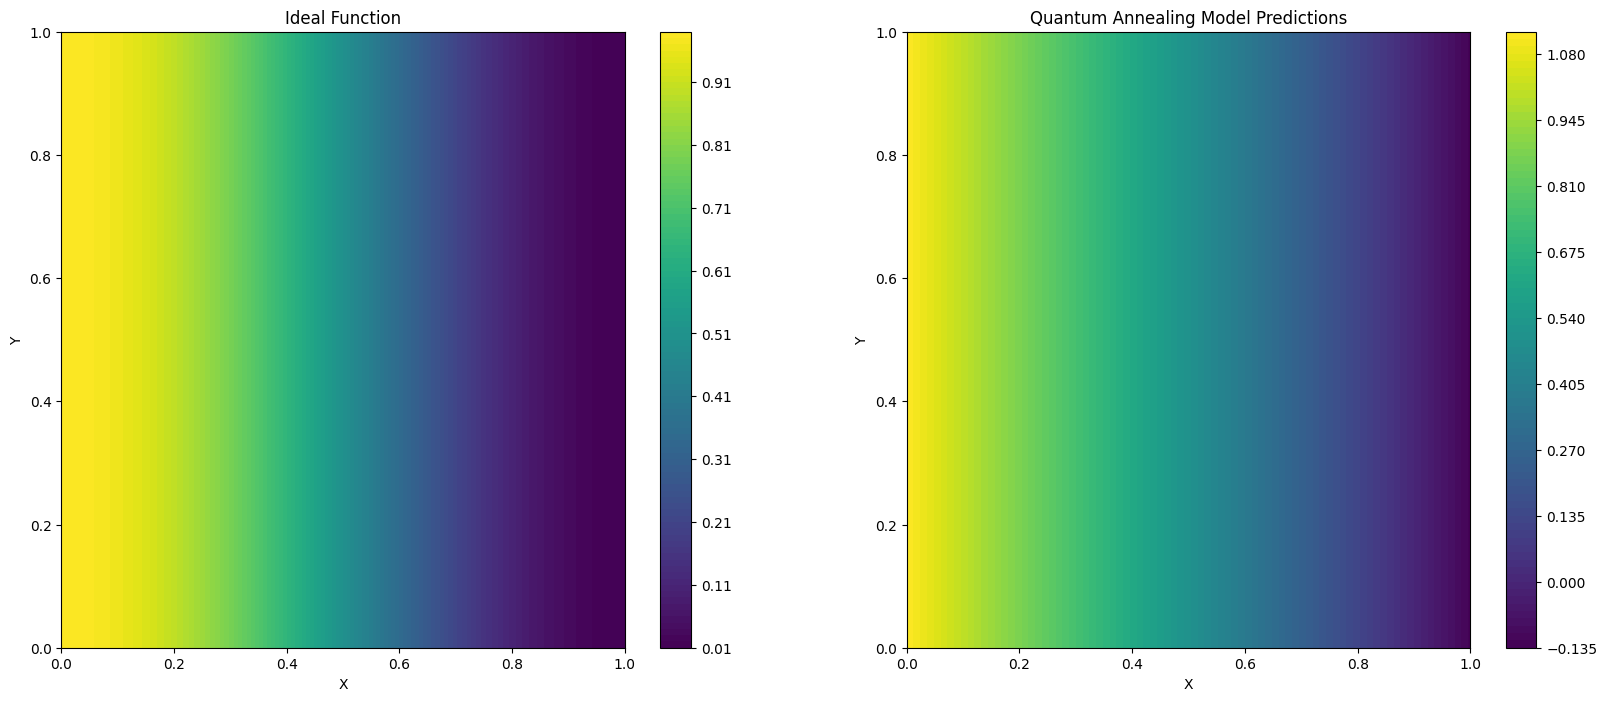

In [61]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.42e-01 | test loss: nan | reg: 1.59e+00 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]


Training time in seconds of lr=0.05: 32.39077233900025
Learning Rate: 0.05, Train MSE: 0.0033971490691775347, Train r2: 0.9724581714609611


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.37e-01 | test loss: nan | reg: 1.36e+00 : 100%|███████| 50/50 [00:32<00:00,  1.55it/s]


Training time in seconds of lr=0.1: 32.284423412998876
Learning Rate: 0.1, Train MSE: 0.002639169432097853, Train r2: 0.9786033669691423


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.39e-01 | test loss: nan | reg: 1.22e+00 : 100%|███████| 50/50 [00:33<00:00,  1.50it/s]


Training time in seconds of lr=0.2: 33.31847241700052
Learning Rate: 0.2, Train MSE: 0.003561836545523484, Train r2: 0.9711229947749569
Best Learning Rate: 0.1 with Train MSE: 0.002639169432097853


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.37e-01 | test loss: nan | reg: 1.36e+00 : 100%|███████| 50/50 [00:33<00:00,  1.50it/s]


Training time in seconds: 33.32318288899842
Layer 0 Bezier coefficients:
[[-0.9639327   0.80616593]
 [ 0.23164338  0.23467767]]
Layer 1 Bezier coefficients:
[[ 0.5140356  -0.03458821]]


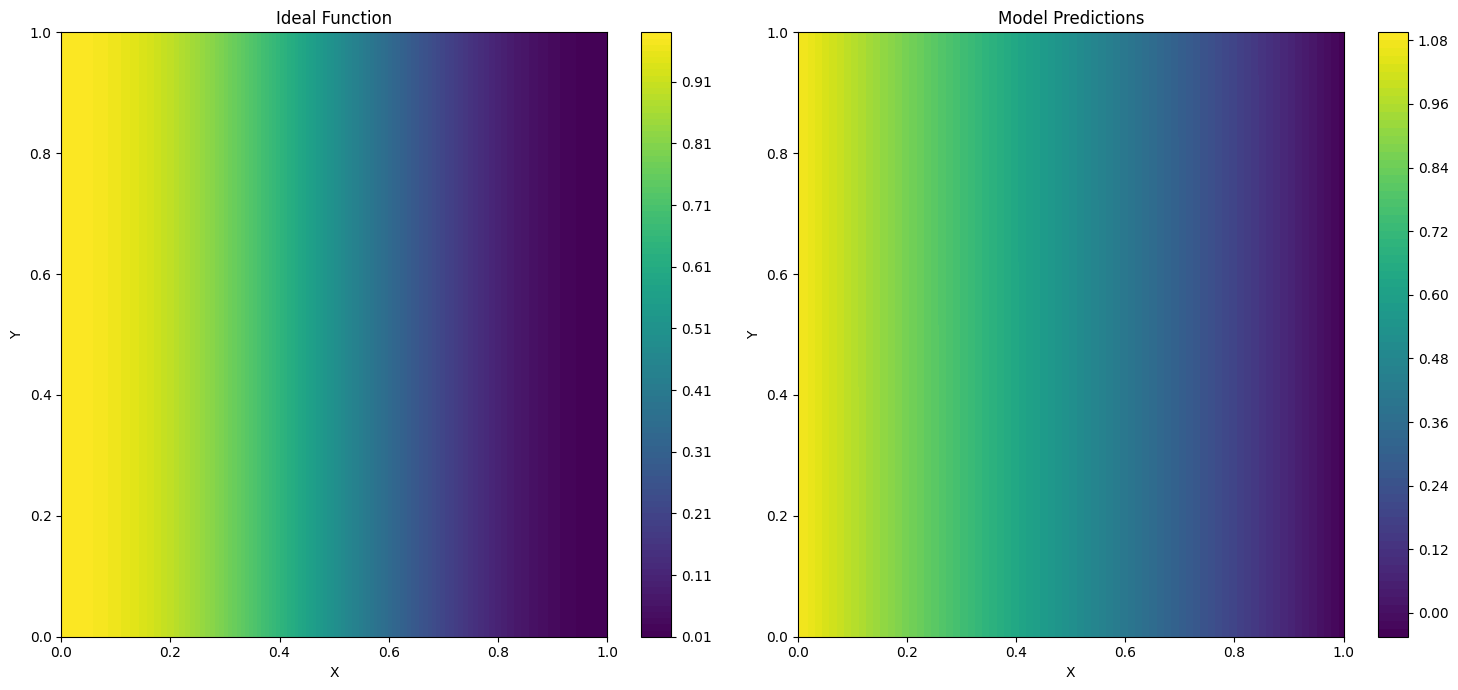

Training time: 33.32318288899842, mse: 0.002651890754695963, r2: 0.9785002309339986


In [62]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_5, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.06e-01 | test loss: nan | reg: 3.44e+00 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]


Training time in seconds of lr=0.05: 32.52275467799882
Learning Rate: 0.05, Train MSE: 0.08483014811419527, Train r2: 0.31225349646841316


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.46e-01 | test loss: nan | reg: 1.10e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds of lr=0.1: 33.16033045800032
Learning Rate: 0.1, Train MSE: 0.02990555517478606, Train r2: 0.7575456195132074


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 2.03e+00 : 100%|███████| 50/50 [00:32<00:00,  1.53it/s]


Training time in seconds of lr=0.2: 32.649629344999994
Learning Rate: 0.2, Train MSE: 0.0024287845177972636, Train r2: 0.980309028133511
Best Learning Rate: 0.2 with Train MSE: 0.0024287845177972636


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 2.03e+00 : 100%|███████| 50/50 [00:32<00:00,  1.55it/s]


Training time in seconds: 32.35306816999946
Layer 0 Bezier coefficients:
[[-0.4209109   0.5340852 ]
 [ 0.05633495  0.05518326]]
Layer 1 Bezier coefficients:
[[ 0.5388553  -0.29571623]]


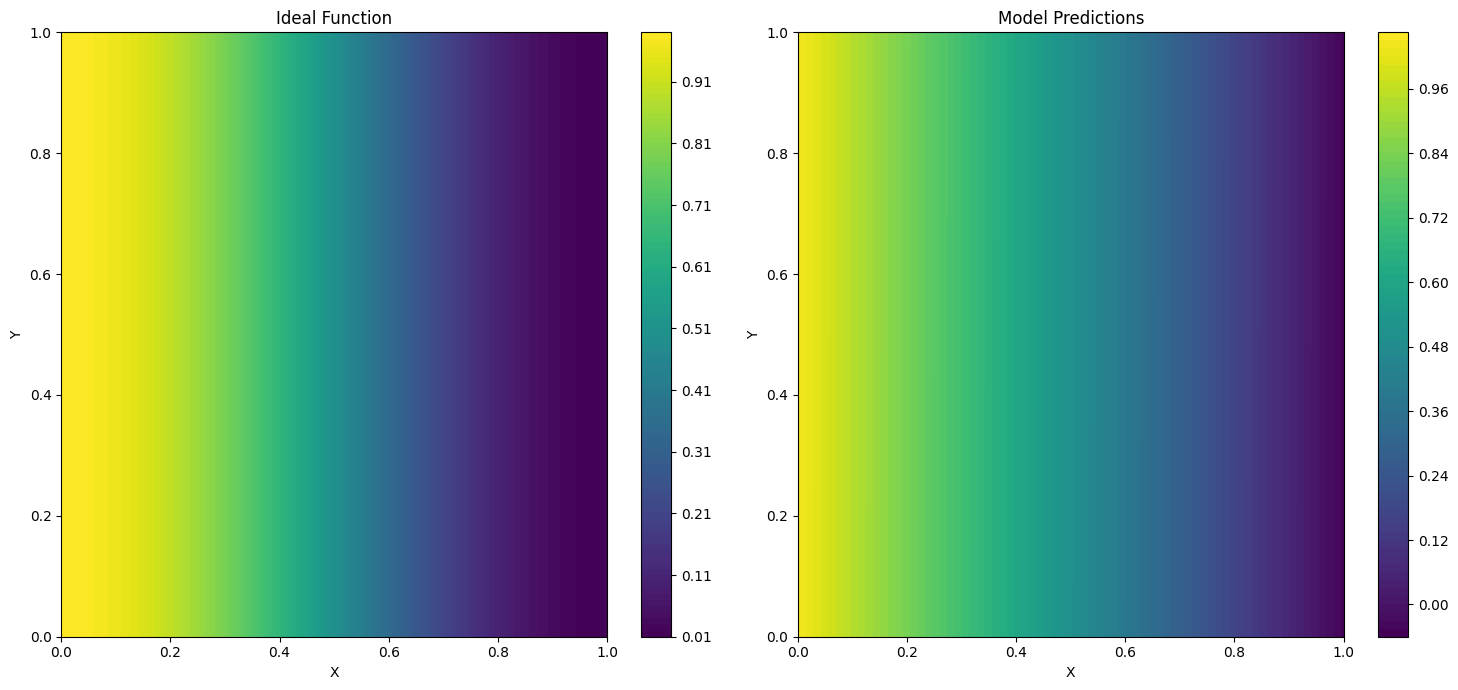

Training time: 32.35306816999946, mse: 0.0024292017905553844, r2: 0.9803056451631071


In [63]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_5, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.43e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]


Training time in seconds of lr=0.05: 32.40644147400053
Learning Rate: 0.05, Train MSE: 0.003194099542290157, Train r2: 0.9741043621757592


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.33e+00 : 100%|███████| 50/50 [00:32<00:00,  1.55it/s]


Training time in seconds of lr=0.1: 32.234694881000905
Learning Rate: 0.1, Train MSE: 0.002400013173955431, Train r2: 0.9805422870817623


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.47e+00 : 100%|███████| 50/50 [00:32<00:00,  1.55it/s]


Training time in seconds of lr=0.2: 32.36002497299887
Learning Rate: 0.2, Train MSE: 0.0023909689417590347, Train r2: 0.9806156117099573
Best Learning Rate: 0.2 with Train MSE: 0.0023909689417590347


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.47e+00 : 100%|███████| 50/50 [00:32<00:00,  1.53it/s]


Training time in seconds: 32.579260216001785
Layer 0 Bezier coefficients:
[[-0.69959617  0.36193523]
 [ 0.04421722  0.04441586]]
Layer 1 Bezier coefficients:
[[ 0.26129332 -0.23050545]]


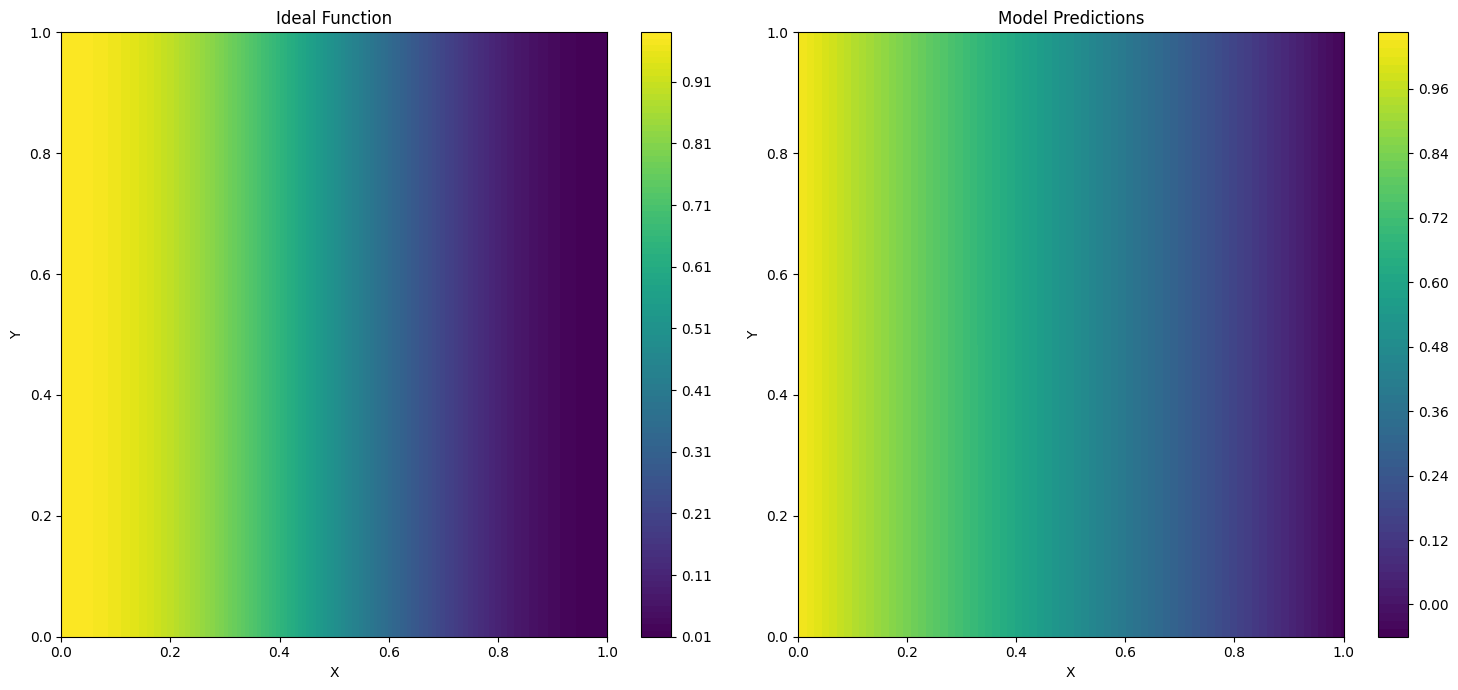

Training time: 32.579260216001785, mse: 0.0023956825493913875, r2: 0.9805773969096742


In [64]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_5, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [65]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.5482209599997439
MSE: 0.0340, r2: 0.7246
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.2736908350004845
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.225541002999307
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 33.32318288899842
MSE: 0.0027, r2: 0.9785
SGD Optimizer Metrics
Total run time in seconds: 32.35306816999946
MSE: 0.0024, r2: 0.9803
AdaGrad Optimizer Metrics
Total run time in seconds: 32.579260216001785
MSE: 0.0024, r2: 0.9806
Array of time for quantum in each training/retraining: [4.542645613999249, 0.481603521999443, 0.5468176539994658, 0.5288106270006411, 0.5482209599997439], total time: 6.648098376998544
Array of time for hybrid in each training/retraining: [7.155537972999905, 3.2772038239997316, 3.289232617000289, 3.2678649510005964, 3.2736908350004845], total time: 20.263530200001004
Array of time for simulated in each training/retrain

# Save the datasets

In [66]:
import pickle

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset1.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 1 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset2.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 2 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset3.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 3 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset4.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 4 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset5.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 5 saved to {dataset_file}")

Dataset 1 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset1.pkl
Dataset 2 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset2.pkl
Dataset 3 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset3.pkl
Dataset 4 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset4.pkl
Dataset 5 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset5.pkl
